In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compute geometric information

ggPIV and bbPIV are cell arrays of the first and second fundamental form evaluated at the PIV coordinate locations in a resized image (0.4 * original pixel dimensions) when compared to the embedding space of the embryo surface. The ith cell is the fundamental form of [X0(i), Y0(i)] evaluation point -- note that X0 and Y0 are unravelled for this indexing. \nX0 and Y0 are the resized image pixel positions of the PIV evaluation points. \ngg and bb are the first and second fundamental forms for each face of rect_embryo_noglue.ply compared to the pullback rect_PIVImageScale.ply
Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Metric at (0, 0)
 [[ 0.144  0.   ]
 [ 0.    30.005]]
Inverse metric at (0, 0)
 [[6.96  0.   ]
 [0.    0.033]]
Christoffel Symbol Shape:  (236, 200, 2, 2, 2)


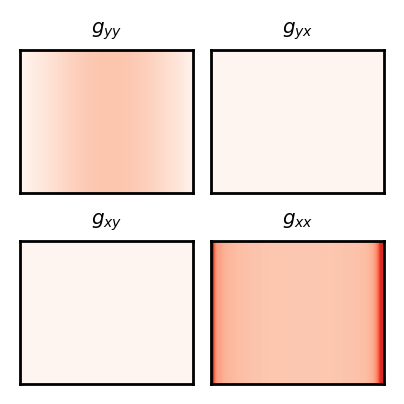

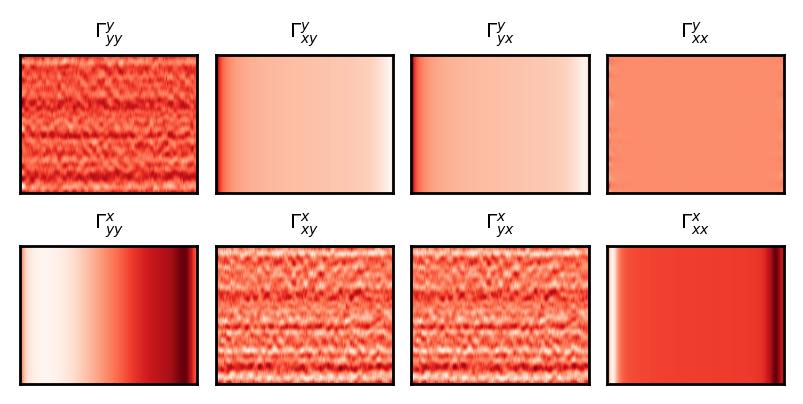

In [6]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *


with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)
    
diff_args = dict(
    dAP=dAP,
    dDV=dDV,
    sigma=5, 
)

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
print(geometry['readme'])
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

#Interpolate metric onto evaluation points
gg = geometry['ggPIV']
gg = np.stack([g for g in gg], axis=0)
gg = np.stack([g for g in gg], axis=0).reshape([X0g.shape[0], Y0g.shape[0], 2, 2])
gg = gg.transpose(1, 0, 2, 3)
gg[..., 0, 1] = 0 #Eliminate off-diagonal metric components
gg[..., 1, 0] = 0 #Eliminate off-diagonal metric components
gg = np.broadcast_to(gg.mean(axis=0, keepdims=True), gg.shape) #Remove DV variation
gg = gg[..., ::-1, ::-1] #Swap y, x coordinates

gij = []
gg = gg.reshape([*gg.shape[:2], 4])
for i in range(gg.shape[-1]):
    gij.append(RectBivariateSpline(Y0g, X0g, gg[..., i])(dv, ap))
gij = np.stack(gij, axis=-1).reshape([dv.shape[0], ap.shape[0], 2, 2])
ginv = np.linalg.inv(gij)

#Print out metric information as a check
np.set_printoptions(precision=3, suppress=True)
print('Metric at (0, 0)\n', gij[0, 0])
print('Inverse metric at (0, 0)\n', ginv[0, 0])

#Build Christoffel symbols
gij_k = gradient(gij.transpose(2, 3, 0, 1), **diff_args)
gij_k = gij_k.transpose(2, 3, 0, 1, 4)

Gijk =  0.5 * (
    np.einsum('yxil,yxjlk->yxijk', ginv, gij_k) + \
    np.einsum('yxil,yxlkj->yxijk', ginv, gij_k) - \
    np.einsum('yxil,yxjkl->yxijk', ginv, gij_k)
)
print('Christoffel Symbol Shape: ', Gijk.shape)

fig, ax = plt.subplots(2, 2, dpi=200, figsize=(2, 2))
ij = ['y', 'x']
vmin = np.min(gij)
vmax = np.max(gij)
for i in range(2):
    for j in range(2):
        color_2D(ax[i, j], gij[..., i, j], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[i, j].set_title('$g_{%s %s}$' % (ij[i], ij[j]))
        ax[i, j].set_aspect('auto')
plt.tight_layout()

fig, ax = plt.subplots(2, 4, dpi=200, figsize=(4, 2))
vmin = np.min(Gijk)
vmax = np.max(Gijk)
for i in range(2):
    for j in range(2):
        for k in range(2):
            color_2D(ax[i, 2*k+j], Gijk[..., i, j, k], cmap='Reds')#, vmin=vmin, vmax=vmax)
            ax[i, 2*k+j].set_title('$\\Gamma^{%s}_{%s %s}$' % (ij[i], ij[j], ij[k]))
            ax[i, 2*k+j].set_aspect('auto')
plt.tight_layout()

np.save('Public/christoffel_symbols', Gijk)


def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

## Load geometric information

In [3]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *


with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


# Integrating both models simultaneously

Integration status:  0 The solver successfully reached the end of the integration interval.


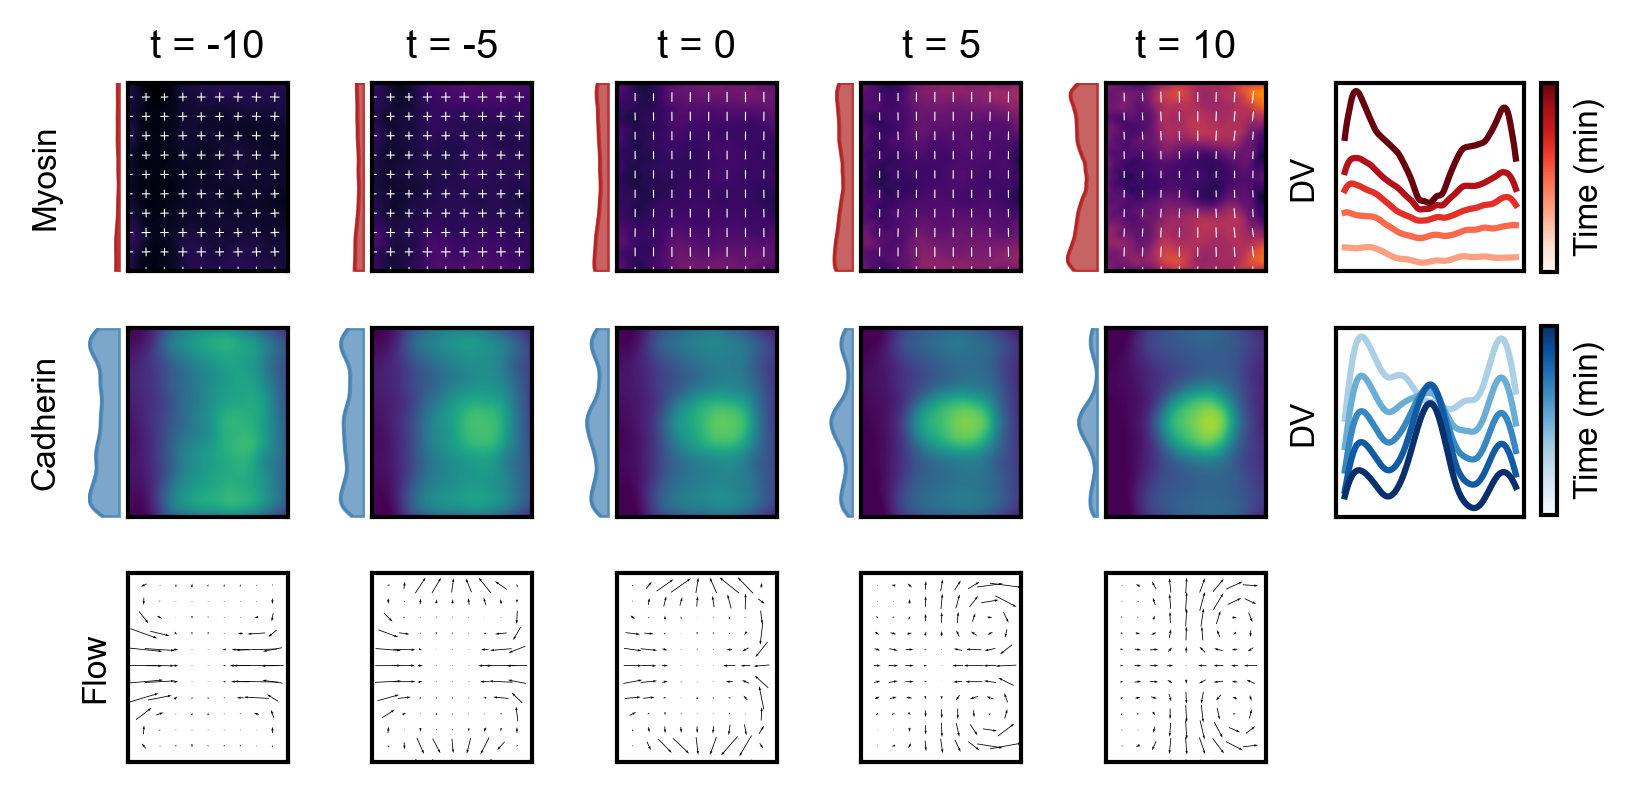

In [23]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    try:
        plot_tensor2D(ax, z, **kwargs)
    except:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=5, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(N*0.9+1, 3), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    offset = 20
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + offset)/ (np.max(t) + offset))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + offset)/ (np.max(t) + offset))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
        ax1[2, -1].set_visible(False)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])
    
    for i in range(ax1.shape[0]):
        for j in range(ax1.shape[1]-1):
            ax1[i, j].set_aspect('equal')

def rhs(t, y, v_int, ds_int, diff_args, nDV=236, nAP=200):
    mc = y.reshape([5, nDV, nAP])
    m = mc[:4].reshape([2, 2, nDV, nAP])
    c = mc[4:].squeeze()

    d1_m = covariant_gradient(m, **diff_args)
    d1_c = covariant_gradient(c, **diff_args)
    v = v_int(t)
    d1_v = covariant_gradient(v, **diff_args)

    O = -0.5 * (np.einsum('iyxj->ijyx', d1_v) - np.einsum('jyxi->ijyx', d1_v))
    E = 0.5 * (np.einsum('iyxj->ijyx', d1_v) + np.einsum('jyxi->ijyx', d1_v))

    deviatoric = m - 0.5 * np.einsum('kkyx,ij->ijyx', m, np.eye(2))

    m_0 = np.linalg.norm(m, axis=(0, 1), keepdims=True).mean(axis=(2, 3), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

    devE = np.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / m_0 
    E_passive = E - E_active

    mE = np.einsum('ikyx,kjyx->ijyx', m, E_passive) + np.einsum('ikyx,kjyx->ijyx', E_passive, m) 

    ds = ds_int(t)
    dv = gamma_dv[:, :, None, None]

    #D_t c = -0.025 c + 0.064 c trE + 0.261 Gamma^D
    cdot =  -1.000 * np.einsum('iyx,yxi->yx', v, d1_c)
    cdot += -0.025 * c
    cdot += -0.2 * np.einsum('yx,iyxi->yx', c, d1_v)
    cdot +=  0.25 * ds

    trm = np.einsum('kkyx->yx', m)[None, None]

    mdot =  -1.000 * np.einsum('kyx,ijyxk->ijyx', v, d1_m)
    mdot -= +1.000 * np.einsum('ikyx,kjyx->ijyx', O, m)
    mdot -= -1.000 * np.einsum('ikyx,kjyx->ijyx', m, O)
    mdot += -0.2 * m
    mdot += (3. - 1. * c)[None, None] * mE
    mdot += trm * (0.2 * dv + 0.11 * m)

    mcdot = np.concatenate([
        mdot.reshape([4, nDV, nAP]),
        cdot.reshape([1, nDV, nAP]),
    ])

    return mcdot.flatten()
    
def integrate(m0, c0, v0, gamma_d0, gamma_dv, t, YY, XX, t_eval=None):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field and two source fields
    ''' 
    #Set up interpolators for control fields
    v_int = interp1d(t, v0, axis=0)
    ds_int = interp1d(t, gamma_d0, axis=0)
    
    #Set up differentiators
    nDV = YY.shape[0]
    nAP = XX.shape[0]
    
    dAP = XX[1] - XX[0]
    dDV = YY[1] - YY[0]
    diff_args = dict(
        dAP=dAP,
        dDV=dDV,
        sigma=3, 
    )

    mc0 = np.concatenate([
        m0.reshape([4, nDV, nAP]),
        c0.reshape([1, nDV, nAP])
    ])
    
    y0 = mc0.flatten()
    if t_eval is None:
        t_eval = t
    out = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t_eval, 
                    args=(v_int, ds_int, diff_args, nDV, nAP))
    print('Integration status: ', out['status'], out['message'])
    mc = out['y'].T.reshape([-1, 5, nDV, nAP])
    m = mc[:, :4].reshape([-1, 2, 2, nDV, nAP])
    c = mc[:, 4:].reshape([-1, nDV, nAP])
    v = v_int(t_eval)
    
    return m, c, v, out['t']

from utils.decomposition_utils import LeftRightSymmetrize
with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    c0 = data['fields/c'][t_mask, ...][()]
    v = data['fields/v'][t_mask, ...][()]
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...]
    gamma_dv = data['X_raw/Static_DV'][0, :, :, 0, 0]
    
    sigma = 10
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    v = LeftRightSymmetrize().fit_transform(v)
    
    t0 = t[t_mask, ...]
    
    v_int = interp1d(t0, v, axis=0)
    ds_int = interp1d(t0, gamma_d, axis=0)
    
    mask = np.s_[..., 20:-20, 0:-25]
    
    #If we're using synthetic ICs
    '''
    m0_norm = np.linalg.norm(m0[0], axis=(0, 1)).mean()
    m0_syn = np.array([[1, 0], [0, .95]]) * m0_norm
    m0_syn = np.broadcast_to(m0_syn[..., None, None], m0[0].shape)

    c0_min, c0_max = np.min(c0[0, :, 50:-50]), np.max(c0[0, :, 50:-50])
    dv_gradient = np.linspace(c0_min, c0_max, 236//2)
    c0_syn = np.concatenate([dv_gradient, dv_gradient[::-1]])
    c0_syn = np.broadcast_to(c0_syn[:, None], c0[0].shape)

    v = v_int(t0)
    m, c, v, t = integrate(m0_syn, c0_syn, v, gamma_d, gamma_dv, t0, dv, ap)
    plot(m, c, v, t, N=5, mask=mask)
    '''
    
    #If we're comparing with experimental data
    #v = v_int(t0)
    m, c, v, t = integrate(m0[0], c0[0], v, gamma_d, gamma_dv, t0, dv, ap)
    
    mnorm = np.linalg.norm(m0, axis=(1, 2))
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    cmin = np.min(c0)
    cmax = np.max(c0)
    
    plot(m, c, v, t, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax, mask=mask)
    #plot(m0, c0, v, t, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax)
    plt.savefig('Figures/MyoCad_Integration.svg', bbox_inches='tight')

(21,) (21,)


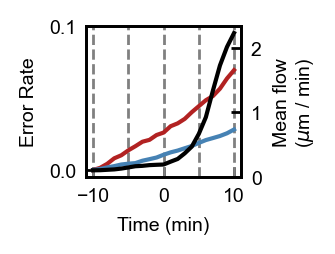

In [71]:
#Demonstrate ensemble of cell trajectories
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 7

fig, ax = plt.subplots(figsize=(1., 1.))

for tt in [-10, -5, 0, 5, 10]:
    ax.axvline(tt, color='grey', linestyle='--', linewidth=1)


ax2 = ax.twinx()
ax2.plot(t, np.linalg.norm(v, axis=1).mean(axis=(1, 2)), color='black')
ax.set_xticks([-10, 0, 10])
ax.set_xlabel('Time (min)')
ax2.set_ylabel('Mean flow\n($\mu$m / min)')
ax2.set_yticks([0, 1, 2])

    
res_m = mean_norm_residual(m0[mask], m[mask]).mean(axis=(1, 2))
res_c = residual(c0[mask], c[mask]).mean(axis=(1, 2))

print(res_m.shape, res_c.shape)

ax.plot(t, res_m, color='firebrick')
ax.plot(t, res_c, color='steelblue')
ax.set_ylabel('Error Rate')
ax.set_ylim([-0.005, 0.1])
ax.set_yticks([0, 0.1])

plt.savefig('Figures/ClosedLoop_Accuracy.svg', bbox_inches='tight')

Text(0.5, 1.0, 'Cadherin (t = -10)')

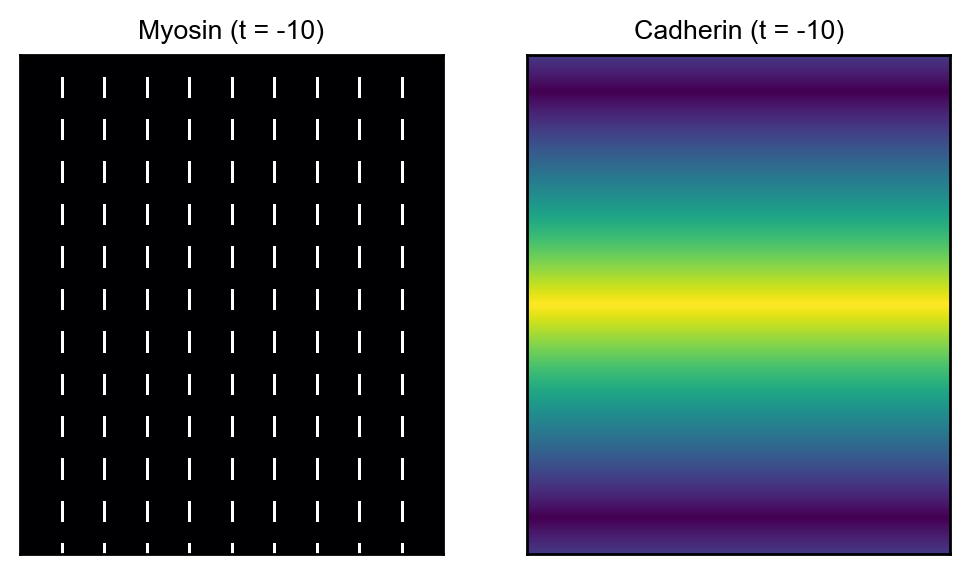

In [15]:
#Synthetic initial condition

m0_norm = np.linalg.norm(m0[0], axis=(0, 1)).mean()
m0_syn = np.array([[1, 0], [0, 0.5]]) * m0_norm
m0_syn = np.broadcast_to(m0_syn[..., None, None], m0[0].shape)

c0_min, c0_max = np.min(c0[0, :, 50:-50]), np.max(c0[0, :, 50:-50])
dv_gradient = np.linspace(c0_min, c0_max, 236//2)
c0_syn = np.concatenate([dv_gradient, dv_gradient[::-1]])
c0_syn = np.broadcast_to(c0_syn[:, None], c0[0].shape)

fig, ax = plt.subplots(1, 2, dpi=200)
plot_tensor2D(ax[0], m0_syn)
color_2D(ax[1], embryo_pad(c0_syn), cmap='viridis')

ax[0].set_title('Myosin (t = -10)')
ax[1].set_title('Cadherin (t = -10)')

# Integrating ICs from mutant data

(107, 2, 2, 236, 200) (107, 2, 236, 200)


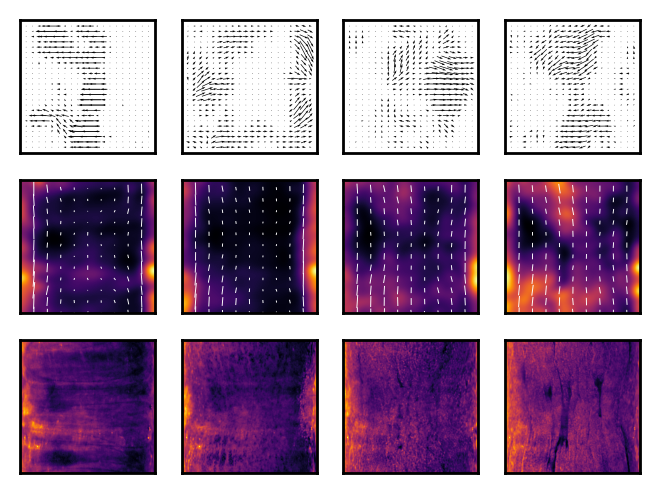

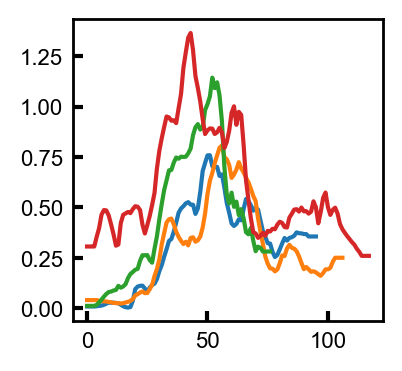

In [178]:
loaddir = 'Public/toll[RM9]/Sqh-GFP/'
loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 1
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

raw = np.load(os.path.join(edir, 'raw2D.npy'), mmap_mode='r')
m = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
print(m.shape, v.shape)

fig, ax = plt.subplots(3, 4, figsize=(4, 3), dpi=200)
for i, tt in enumerate(np.linspace(0, m.shape[0]-1, 4, dtype=int)):
    plot_vector2D(ax[0, i], v[tt])
    plot_tensor2D(ax[1, i], m[tt])
    color_2D(ax[2, i], raw[tt])
    ax[0, i].set_aspect('auto')
    ax[1, i].set_aspect('auto')
    ax[2, i].set_aspect('auto')

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)

for eId in embryoIDs:
    edir = os.path.join(loaddir, str(eId))
    v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
    ax.plot(np.arange(v.shape[0]), np.linalg.norm(v, axis=1).mean(axis=(1, 2)))


(21, 2, 2, 236, 200) (21, 2, 236, 200)
(21,)
Integration status:  0 The solver successfully reached the end of the integration interval.


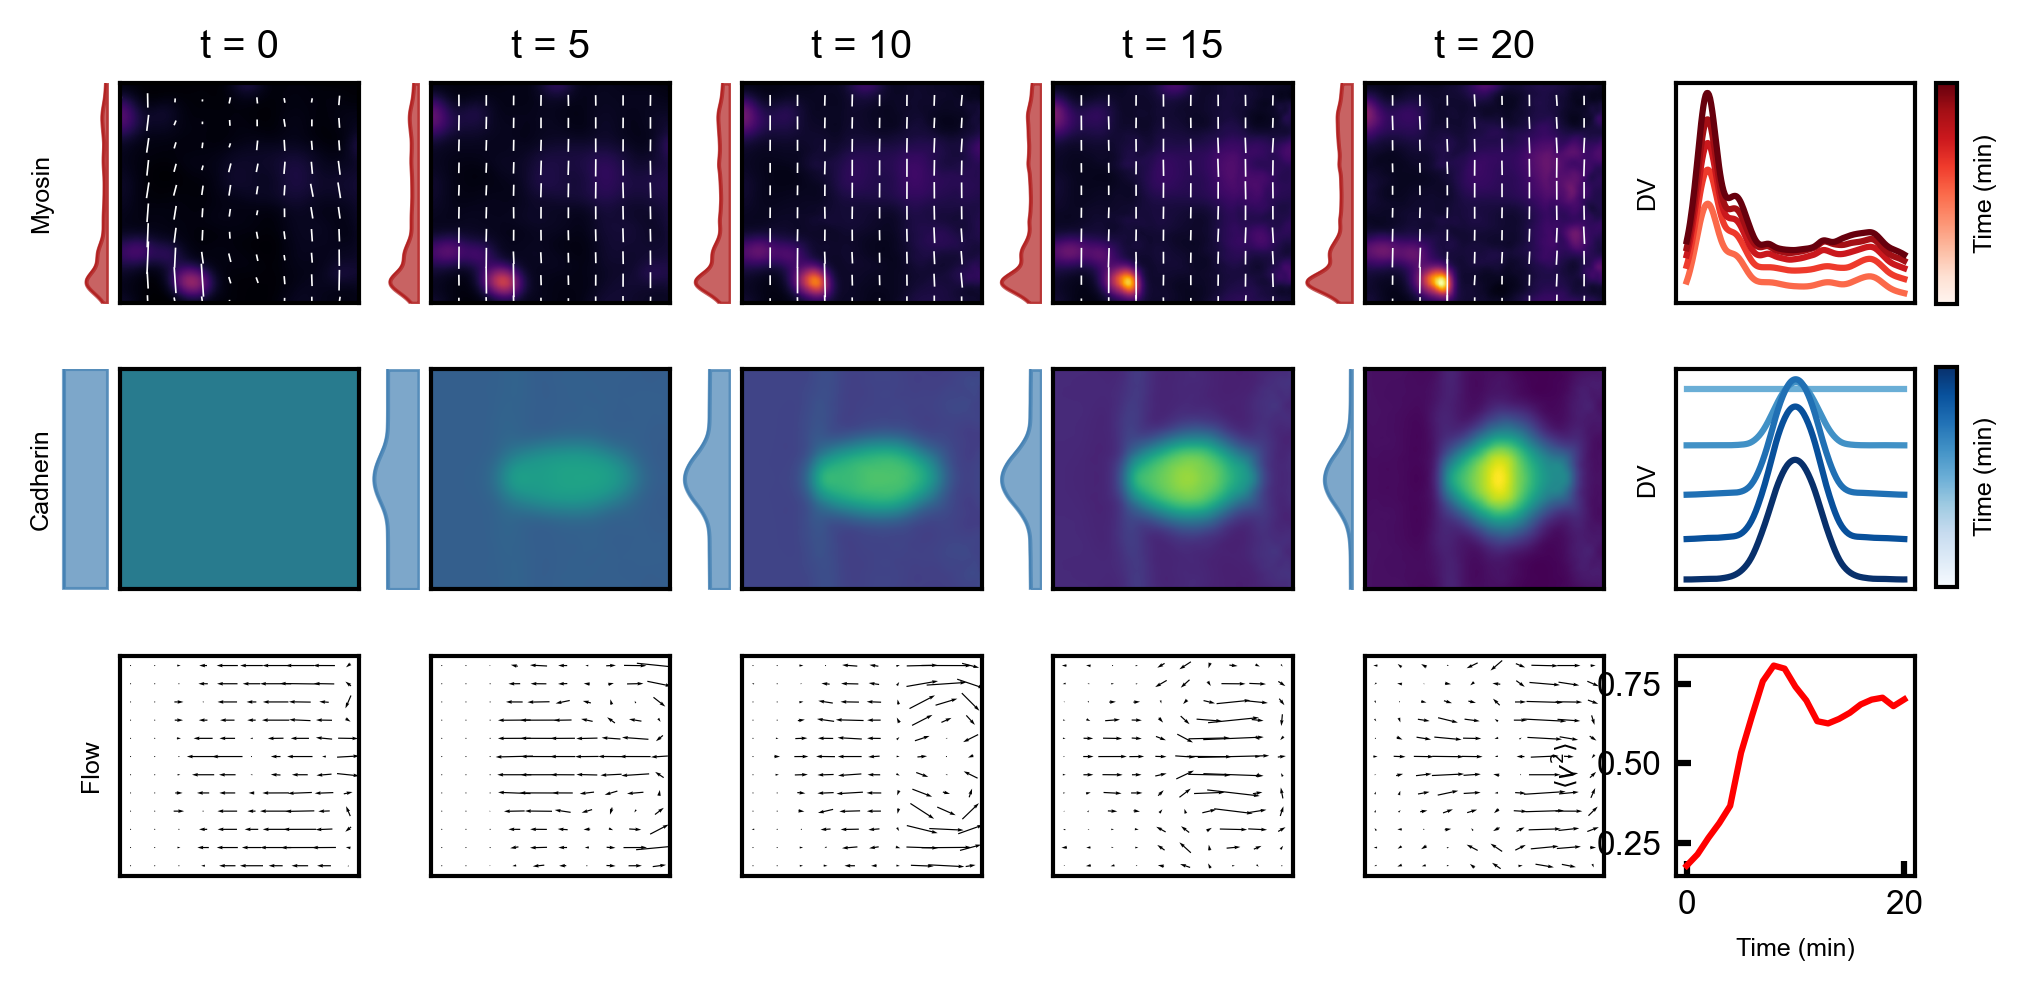

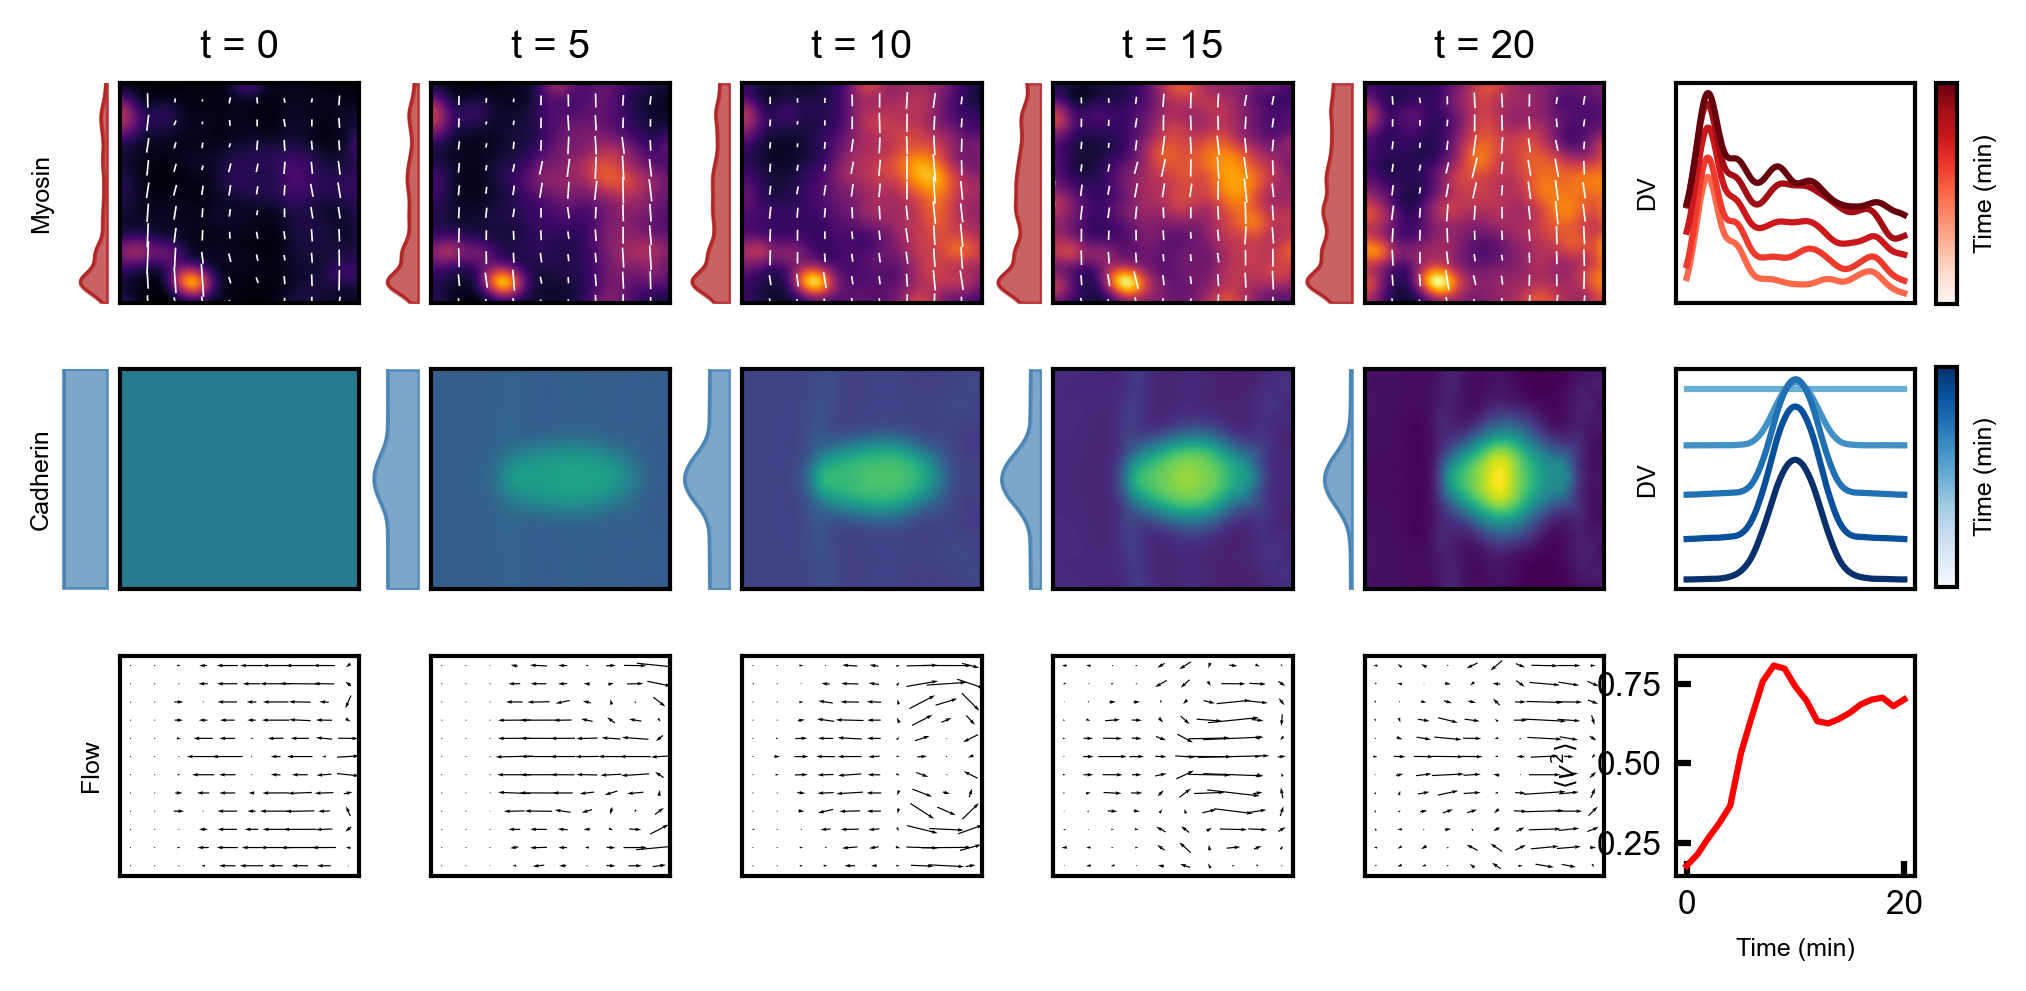

In [184]:

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    try:
        plot_tensor2D(ax, z, **kwargs)
    except:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=6, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + 20)/ (np.max(t) + 20))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + 20)/ (np.max(t) + 20))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[2, -1].plot(t, np.linalg.norm(v, axis=1).mean(axis=(-2, -1)), color='red')
    ax1[2, -1].set(xlabel='Time (min)', ylabel=r'$\langle v^2 \rangle$')
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for a in ax1.flatten():
        a.set_aspect('auto')

loaddir = 'Public/toll[RM9]/Sqh-GFP/'
#loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 2
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

t0 = 15
N = 21
m0 = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')[t0:t0+N]
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')[t0:t0+N]
print(m.shape, v.shape)

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = 0
    tmax = 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...]
    gamma_dv = data['X_raw/Static_DV'][0, :, :, 0, 0]    
    c0 = data['fields/c'][t_mask, ...][()]

    
    sigma = 10
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    v = LeftRightSymmetrize().fit_transform(v)
    
    t0 = t[t_mask, ...]
    print(t0.shape)
    
    v_int = interp1d(t0, v, axis=0)
    ds_int = interp1d(t0, gamma_d, axis=0)
    
    mask = np.s_[..., 20:-20, 0:-25]
        
    c0_syn = np.ones(c0[0].shape) * np.mean(c0)

    v = v_int(t0)
    m, c, v, t = integrate(m0[0], c0_syn, v, gamma_d, gamma_dv, t0, dv, ap)
    plot(m, c, v, t, N=5, mask=mask)
    plot(m0, c, v, t, N=5, mask=mask)

# Physics-inspired closed loop dynamics

In [166]:
from utils.translation_utils import *
from utils.decomposition_utils import *
from library_generation.extra_functions import *
        
libraries = [
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', 'cyt_SVDPipeline_PMG_CF.pkl'), 
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/WT/ECad-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij', 'c']),
    lambda data: scalar_tensor_couple(data, ['c', 'c^2'], ['E', 'm_ij']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: add_dorsal_sources(data, couple='c', key='ELLIPSE_A=0.5_B=0.25'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


embryoIDs = None
for key, path, _, _ in libraries:
    with h5py.File(os.path.join(path, 'derivative_library.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.union(eIds)
embryoIDs = list(embryoIDs)
#embryoIDs = ['ensemble']
#embryoIDs = ['202001280915']
with h5py.File('Public/symmetric_dynamics_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names = fill_group_info(data, embryoID, libraries)
        collect_library(group, 
                        libraries, 
                        feature_names, 
                        extra_functions=extra_functions)
        decompose_library(group, libraries, window_length=9)
        print('DONE')

202001281800
Added /202001281800 to c library
Added ensemble to m_ij library
Added /202001281800 to v library
Decomposing library for c
Computing time derivative for c
Not computing dynamics for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202009041145
Added ensemble to c library
Added /202009041145 to m_ij library
Added ensemble to v library
Added /202009041145 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
ensemble
Added /ensemble to c library
Added /ensemble to m_ij library
Added /ensemble to v library
Added /ensemble to v library
Decomposing library for c
Computing time derivative for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202001280915
Added /202001280915 to c library
Added ensemble to m_ij library
Added /202001280915 to v library
Decomposing library 

Adding Material Derivative terms to LHS
(147, 16, 7) (147, 16, 1)
(147, 16, 7) (147, 16, 1)
D_t c  = 0.118 Dorsal_Source + -0.043 c + 0.001 c Tr(m_ij) + 0.013 c^2 + -0.427 c^2 Tr(E)
PCA Component R2=-6.89527	MSE=0.46894


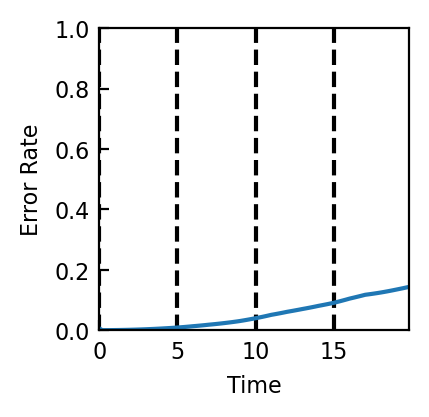

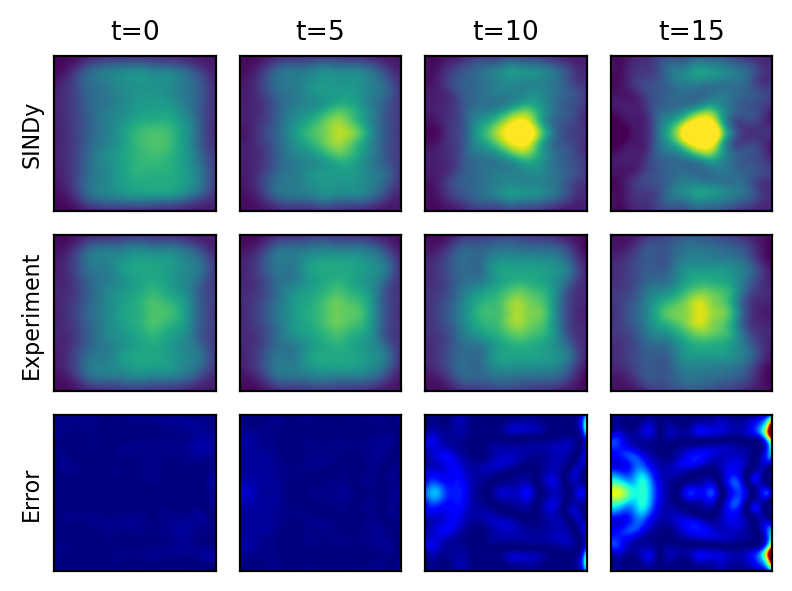

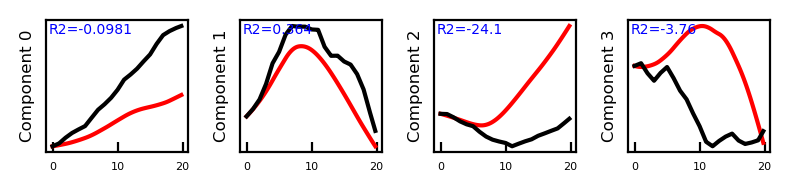

In [159]:
from utils.translation_utils import *

lib_path = 'Public/WT/ECad-GFP'
lib_key = 'c'

plt.rcParams['figure.dpi'] = 200

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'cyt_SVDPipeline_PMG_CF.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.93
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=5, tmax=15,
        scale_units=True,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr,
        threshold=1e-2,
        alpha=1e0,
        n_candidates_to_drop=0,
        n_models=5,
        overleaf_only=True,
    )
    info_all = dict(
        key=lib_key,
        tmin=0, tmax=20,
        scale_units=True,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr**2,
        threshold=1e-1,
        alpha=1e-1,
        n_candidates_to_drop=2,
        n_models=10,
        n_subset=30,
        overleaf_only=False,
    )
    info = info_all
    sindy = fit_sindy_model(h5f, **info)


    data = h5f['ensemble']
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = 0, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/cyt_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'viridis'
    plt.rcParams['font.size'] = 8
    sindy_predictions_plot(pred, interp, model, times, keep, data, plot_fn=color_2D)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])

Adding Material Derivative terms to LHS
(106, 16, 26) (106, 16, 1)
(106, 16, 26) (106, 16, 1)
D_t m_ij  = -0.003 E_passive + 1.486 E_passive Tr(m_ij) + -0.027 Static_DV Tr(m_ij) + 0.012 c Static_DV Tr(m_ij) + -0.150 c m_ij + 0.088 c m_ij Tr(m_ij) + -0.362 c {m_ij, E_passive} + 0.366 m_ij + -0.067 m_ij Tr(m_ij) + 0.591 {m_ij, E_passive}
PCA Component R2=-3.51722	MSE=0.729732


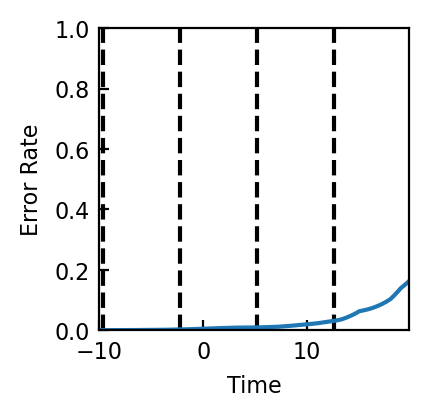

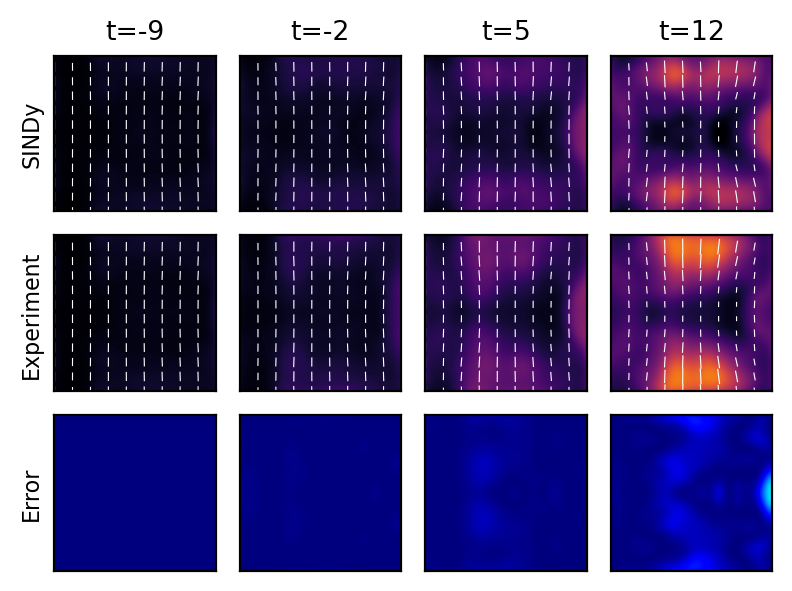

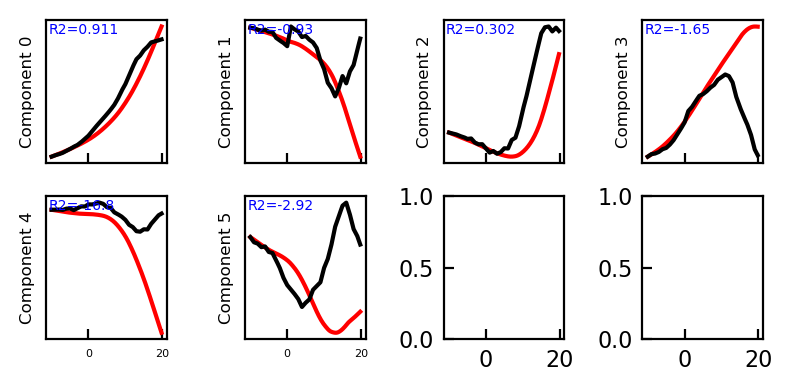

In [160]:
from utils.translation_utils import *

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline.pkl'), 'rb'))
    #model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.95
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=-8, tmax=10,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr**2,
        threshold=1e-2,
        alpha=1e-1,
        n_candidates_to_drop=1,
        n_models=10,
        overleaf_only=True,
    )
    info_all = dict(
        key=lib_key,
        tmin=-5, tmax=10,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr**2,
        threshold=1e-3,
        alpha=2e2,
        n_candidates_to_drop=10,
        n_models=100,
        n_subset=30,
        overleaf_only=False,
    )
    info = info_all
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    #data = h5f['202001280915']
    #data = h5f['202001282000']
    
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = -10, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/tensor_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'inferno'
    sindy_predictions_plot(pred, interp, model, times, keep, data)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])

# Building ensembles of models

To evaluate which terms are more or less accurate to these models, we are going to back off the accuracy requirement a bit. Instead, we'll generate models at different sparsity thresholds and randomly leave terms out of the libraries. This way we can get an ensemble of nearly equivalent models with different accuracy scores.

At the same time, we'll make two modifications to the fitting procedure. First, we'll eliminate pair rule genes from the library, as we don't see them except at very low sparsity. Second, we will fit on a narrower range $t \in [25, 40]$ and test on $t \in [15, 45]$

In [ ]:
def collect_decomposed_data(h5f, key, tmin, tmax, keep, scale_units=False, material_derivative=True):
    ''' 
    Collect the PCA data froma  given h5f library and return X, U, X_dot, and the relevant variable names

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything

        the returned scale_array is the unit factor we need to multiply by to get to units of key / time
        these are the units of the feature
        Each feature should be multiplied by these units, and its coefficient should be divided by them
    '''
    feature_names = list(h5f['X_cpt'][key].attrs['feature_names'])

    
    t_X = h5f['t'][()].astype(int)    
    t_mask = np.logical_and(t_X >= tmin, t_X <= tmax)
    times = t_X[t_mask]

    X = h5f['X_cpt'][key][t_mask, ...][..., keep, :][()]
    X_dot = h5f['X_dot_cpt'][key][t_mask, ...][..., keep, :][()]

    if material_derivative:
        adv = 'v dot grad %s' % key 
        if adv in feature_names:
            loc = feature_names.index(adv)
            X_dot += X[..., loc:loc+1]
            X = np.delete(X, loc, axis=-1)
            feature_names.remove(adv)

        cor = '[O, %s]' % key 
        if cor in feature_names:
            loc = feature_names.index(cor)
            X_dot -= X[..., loc:loc+1]
            X = np.delete(X, loc, axis=-1)
            feature_names.remove(cor)

    #Eliminate other advection terms because they involve gradients of proteins
    adv = [feature for feature in feature_names if 'v dot grad' in feature]
    for a in adv:
        loc = feature_names.index(a)
        X = np.delete(X, loc, axis=-1)
        feature_names.remove(a)

    scale_array = np.ones(X.shape[-1])
    if scale_units:
        fields = h5f['fields']
        base = fields[key].attrs['std']
        for i, feature in enumerate(feature_names):
            attrs = h5f['X_raw'][feature].attrs
            for unit in attrs:
                if unit in fields and not unit == 'v':
                    scale_array[i] /= (fields[unit].attrs['std'] / base) ** attrs[unit]

    return X, X_dot, times, feature_names, scale_array

from sklearn.model_selection import train_test_split
def fit_sindy_model(h5f, 
                    key,
                    keep,
                    tmin=25, 
                    tmax=40, 
                    threshold=1e-1, 
                    alpha=1e-1, 
                    n_models=10,
                    n_candidates_to_drop=5,
                    scale_units=False, 
                    material_derivative=False):
    '''
    Fit a SINDy model on data filled by a given key in an h5py file
    Fit range goes from tmin to tmax, and is applied on a set keep of PCA components

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything
        In general, the goal should be to use v as a reference
    '''
    X, X_dot, scales = [], [], []
    eIds = list(h5f.keys())
    for eId in eIds:
        x, x_dot, times, feature_names, scale = collect_decomposed_data(
            h5f[eId],
            key,
            tmin,
            tmax,
            keep,
            scale_units,
            material_derivative)
        X.append(x * scale[:len(feature_names)])
        X_dot.append(x_dot)
        scales.append(scale)

    X_train, X_test, X_dot_train, X_dot_test = train_test_split(X, X_dot, test_size=0.33)
    scales = np.mean(scales, axis=0)
    
    optimizer = ps.EnsembleOptimizer(
        opt=ps.STLSQ(threshold=threshold, alpha=alpha),
        bagging=False,
        library_ensemble=True,
        n_models=n_models,
        n_candidates_to_drop=n_candidates_to_drop,
    )
        
    sindy = ps.SINDy(
        feature_library=ps.IdentityLibrary(),
        optimizer=optimizer,
        feature_names=feature_names,
    )
    sindy.fit(x=X_train, x_dot=X_dot_train, multiple_trajectories=True)

    if material_derivative:
        #sindy.print(lhs=['D_t %s ' % key])
        sindy.material_derivative_ = True
    else:
        #sindy.print(lhs=['d_t %s' % key])
        sindy.material_derivative_ = False
    sindy.model.steps[-1][1].optimizer.coef_[:] *= scales
    return sindy

D_t c = 0.161 Tr(E) Tr(c) c + -14.247 Tr(E) Tr(m) m + 7.127 Tr(c m) m + -1.607 Tr(c) {m, c} + 3.740 Tr(c^2) m + -1.008 Tr(m c) c + -3.712 Tr(m) {c, m} + 16.434 [O, m] + -4.477 m Tr(E) + 0.610 {m, c^2}


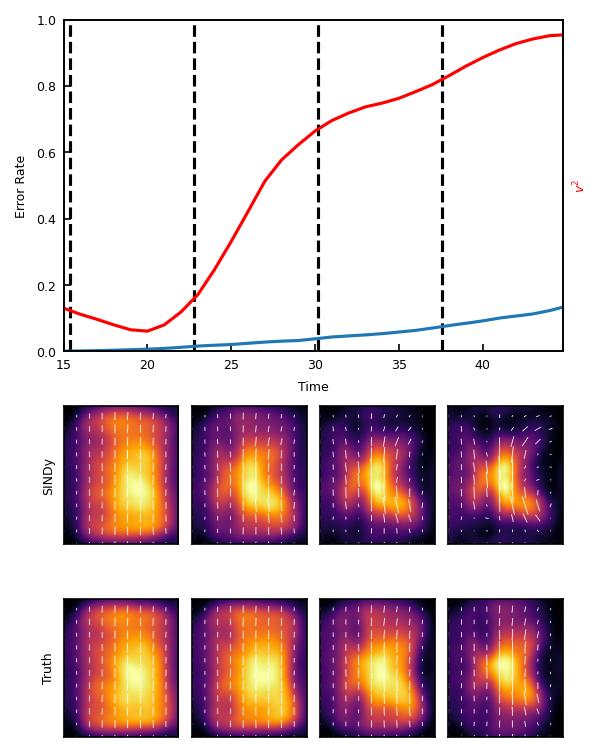

In [156]:
lib_key, lib_path = 'm', 'data/WT/sqh-mCherry'
lib_key, lib_path = 'c', 'data/WT/ECad-GFP'

model = pk.load(open(os.path.join(lib_path, 'tensor_SVDPipeline.pkl'), 'rb'))
info = dict(
    key=lib_key,
    tmin=25,
    tmax=40,
    scale_units=True,
    material_derivative=True,
    n_candidates_to_drop=5,
    n_models=10,
    keep=np.cumsum(model.explained_variance_ratio_) <= 0.9,
    threshold=1e-1,
    alpha=2e-1,
)

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:

    sindy = fit_sindy_model(h5f, **info)
    sindy.print(lhs=['D_t ' + lib_key])
    data = h5f['ensemble']
    tmin, tmax = 15, 45

    pred, interp, times = sindy_predict(data, lib_key, sindy, model, info['keep'], #np.ones_like(info['keep']), 
                                        tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, model, times, np.ones_like(info['keep']), data)

results_df.to_csv('SINDy_ensemble_%s.csv' % lib_key)

In [157]:
lib_key, lib_path = 'm', 'data/WT/sqh-mCherry'
lib_key, lib_path = 'c', 'data/WT/ECad-GFP'

model = pk.load(open(os.path.join(lib_path, 'tensor_SVDPipeline.pkl'), 'rb'))
info = dict(
    key=lib_key,
    tmin=25,
    tmax=40,
    scale_units=False,
    material_derivative=True,
    n_candidates_to_drop=5,
    n_models=10,
    keep=np.cumsum(model.explained_variance_ratio_) <= 0.9,
)

from itertools import product
thresholds = np.geomspace(1e-2, 5e-1, 5)
alphas = np.geomspace(1e-2, 5e-1, 5)
scale_units = [True, False]

results_df = pd.DataFrame()
import warnings
warnings.filterwarnings('ignore')
with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    for threshold, alpha, scale_unit in product(thresholds, alphas, scale_units):
        info['threshold'] = threshold
        info['alpha'] = alpha
        info['scale_units'] = scale_unit

        sindy = fit_sindy_model(h5f, **info)
        features = ['coef_%s' % feature for feature in sindy.feature_names]
        coef_list = np.stack(sindy.optimizer.coef_list + [sindy.optimizer.coef_,])[:, 0]
        df = pd.DataFrame(data=coef_list, columns=features)
        df['threshold'] = info['threshold']
        df['alpha'] = info['alpha']
        df['scale_units'] = info['scale_units']
        df['material_derivative'] = sindy.material_derivative_
        df['key'] = lib_key
        results_df = results_df.append(df, ignore_index=True)

results_df.to_csv('SINDy_ensemble_%s.csv' % lib_key)

/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity 

Text(0.5, 1.0, 'Myosin statistics')

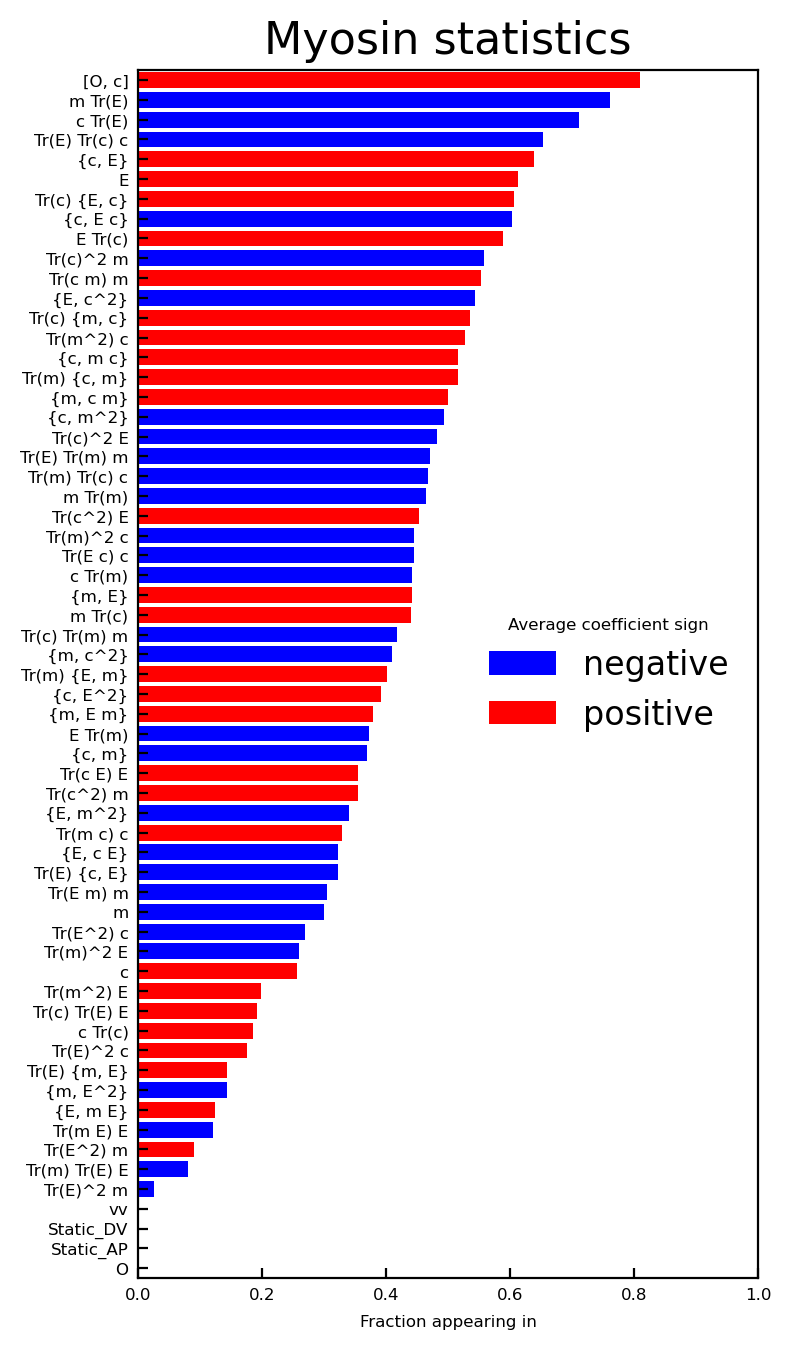

In [195]:
lib_key = 'm'

results_df = pd.read_csv('SINDy_ensemble_%s.csv' % lib_key)
results_df = results_df[results_df.residual != 0]
coefs = results_df.filter(like='coef_')
to_remove = np.sum(coefs.values, axis=1) == 0
results_df = results_df[~to_remove]
results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')].reset_index()
results_df = pd.wide_to_long(results_df, stubnames='coef', i='index', j='feature', sep='_', suffix='.*')
summary = results_df.groupby('feature')['coef'].agg(
    frac_nonzero=lambda x: np.count_nonzero(x) / len(x),
    count_nonzero=np.count_nonzero, 
    count=lambda x: len(x), 
    mean_nonzero=lambda x: np.mean(x[x != 0]), 
    std_nonzero=lambda x: np.std(x[x != 0]),
    sign=lambda x: np.sign(np.mean(x[x != 0])),
).reset_index()
summary = summary.sort_values('frac_nonzero', ascending=True).reset_index(drop=True)
colors = np.zeros([len(summary), 3])
colors[summary.sign < 0, 0] = 1.
colors[summary.sign > 0, 2] = 1
fig, ax = plt.subplots(1, 1, figsize=(4, 8), dpi=200)
ax.barh(
    summary[summary.sign < 0].index,
    summary[summary.sign < 0].frac_nonzero,
    color='blue',
    label='negative'
)
ax.barh(
    summary[summary.sign > 0].index,
    summary[summary.sign > 0].frac_nonzero,
    color='red',
    label='positive'
)
ax.set(yticks=summary.index, yticklabels = summary.feature)
ax.set_ylim([summary.index.min()-0.5, summary.index.max()+0.5])
ax.set_xlim([0, 1])
ax.set_xlabel('Fraction appearing in')
ax.set_ylabel('')
ax.legend(loc='center right', framealpha=0, fontsize=12, title='Average coefficient sign')
ax.set_title('%s statistics' % ('Myosin' if lib_key == 'm' else 'Cadherin'),
             fontsize=16)

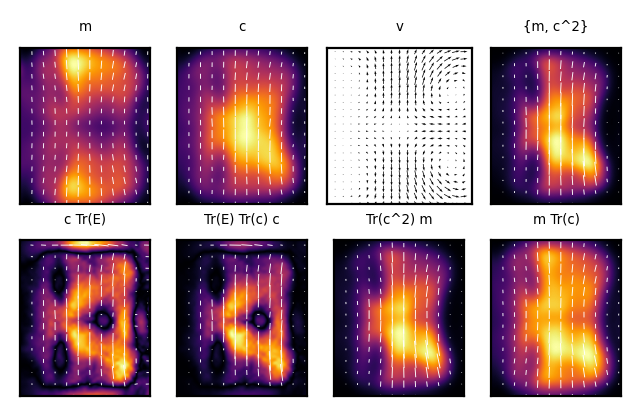

In [200]:
lib_key = 'c'

results_df = pd.read_csv('SINDy_ensemble_%s.csv' % lib_key)
results_df = results_df[results_df.residual != 0]
coefs = results_df.filter(like='coef_')
to_remove = np.sum(coefs.values, axis=1) == 0
results_df = results_df[~to_remove]
results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')].reset_index()
results_df = pd.wide_to_long(results_df, stubnames='coef', i='index', j='feature', sep='_', suffix='.*')
summary = results_df.groupby('feature')['coef'].agg(
    frac_nonzero=lambda x: np.count_nonzero(x) / len(x),
    count_nonzero=np.count_nonzero, 
    count=lambda x: len(x), 
    mean_nonzero=lambda x: np.mean(x[x != 0]), 
    std_nonzero=lambda x: np.std(x[x != 0]),
    sign=lambda x: np.sign(np.mean(x[x != 0])),
).reset_index()
summary = summary.sort_values('frac_nonzero', ascending=False).reset_index(drop=True)
keys = summary[:5].feature.values

from math import ceil
from utils.plot_utils import *

traj = 0
tt = 30
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    ti = np.argmin(np.abs(lib['t'][()] - tt))
    
    n_plots = 3 + len(keys)

    n_cols = 4
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, 
                       figsize=(.8*n_cols, n_rows),
                       sharey=True, sharex=True, dpi=200)

    ax = ax.flatten()
    ax[0].set_title('m')
    plot_tensor2D(ax[0], lib['fields/m'][ti][()][..., 10:-10, 10:-10], skip=skip)
    ax[1].set_title('c')
    plot_tensor2D(ax[1], lib['fields/c'][ti][()][..., 10:-10, 10:-10], skip=skip)
    ax[2].set_title('v')
    plot_vector2D(ax[2], lib['fields/v'][ti][()][..., 10:-10, 10:-10])
    
    for i, key in enumerate(keys):
        if key == 'O':
            color_2D(ax[i+3], lib['X_raw'][key][ti][0, 1, 10:-10, 10:-10], cmap='bwr')
        elif key in lib['X_raw']:
            plot_tensor2D(ax[i+3], lib['X_raw'][key][ti][()][..., 10:-10, 10:-10], skip=skip, linewidth=0.007)
        ax[i+3].set_title(key)

    plt.tight_layout()

# Runt dynamics

We expect pair rule gene stripes to be advected by the flow, i.e. $\partial_t R + \mathbf{v} \cdot \nabla R = 0$

## PCA Information

       time
set        
test    199
train   299


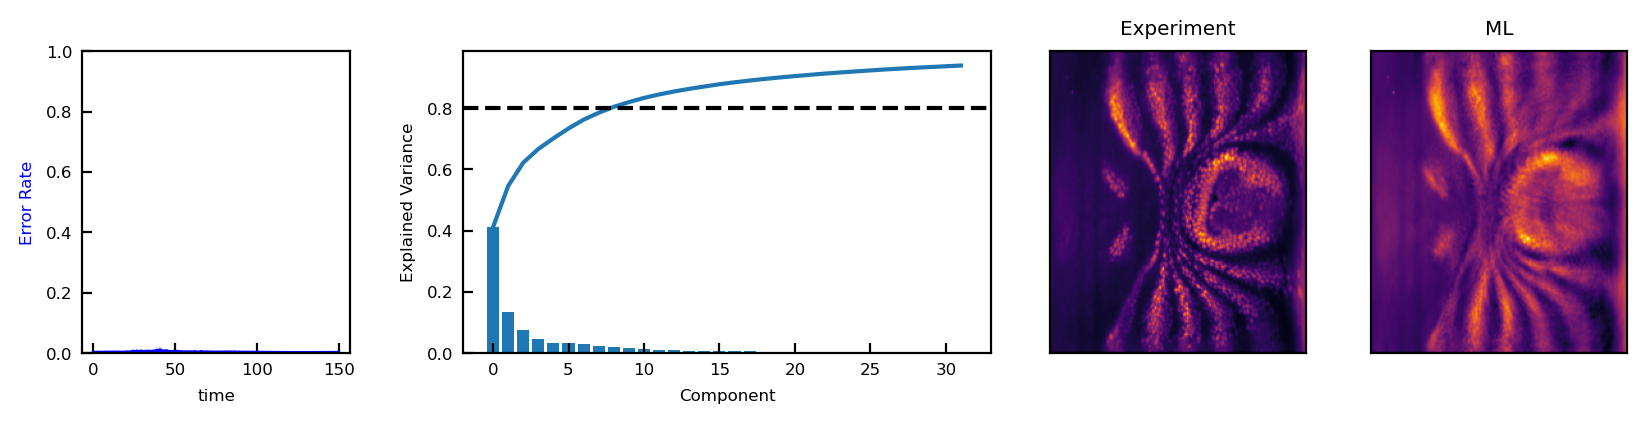

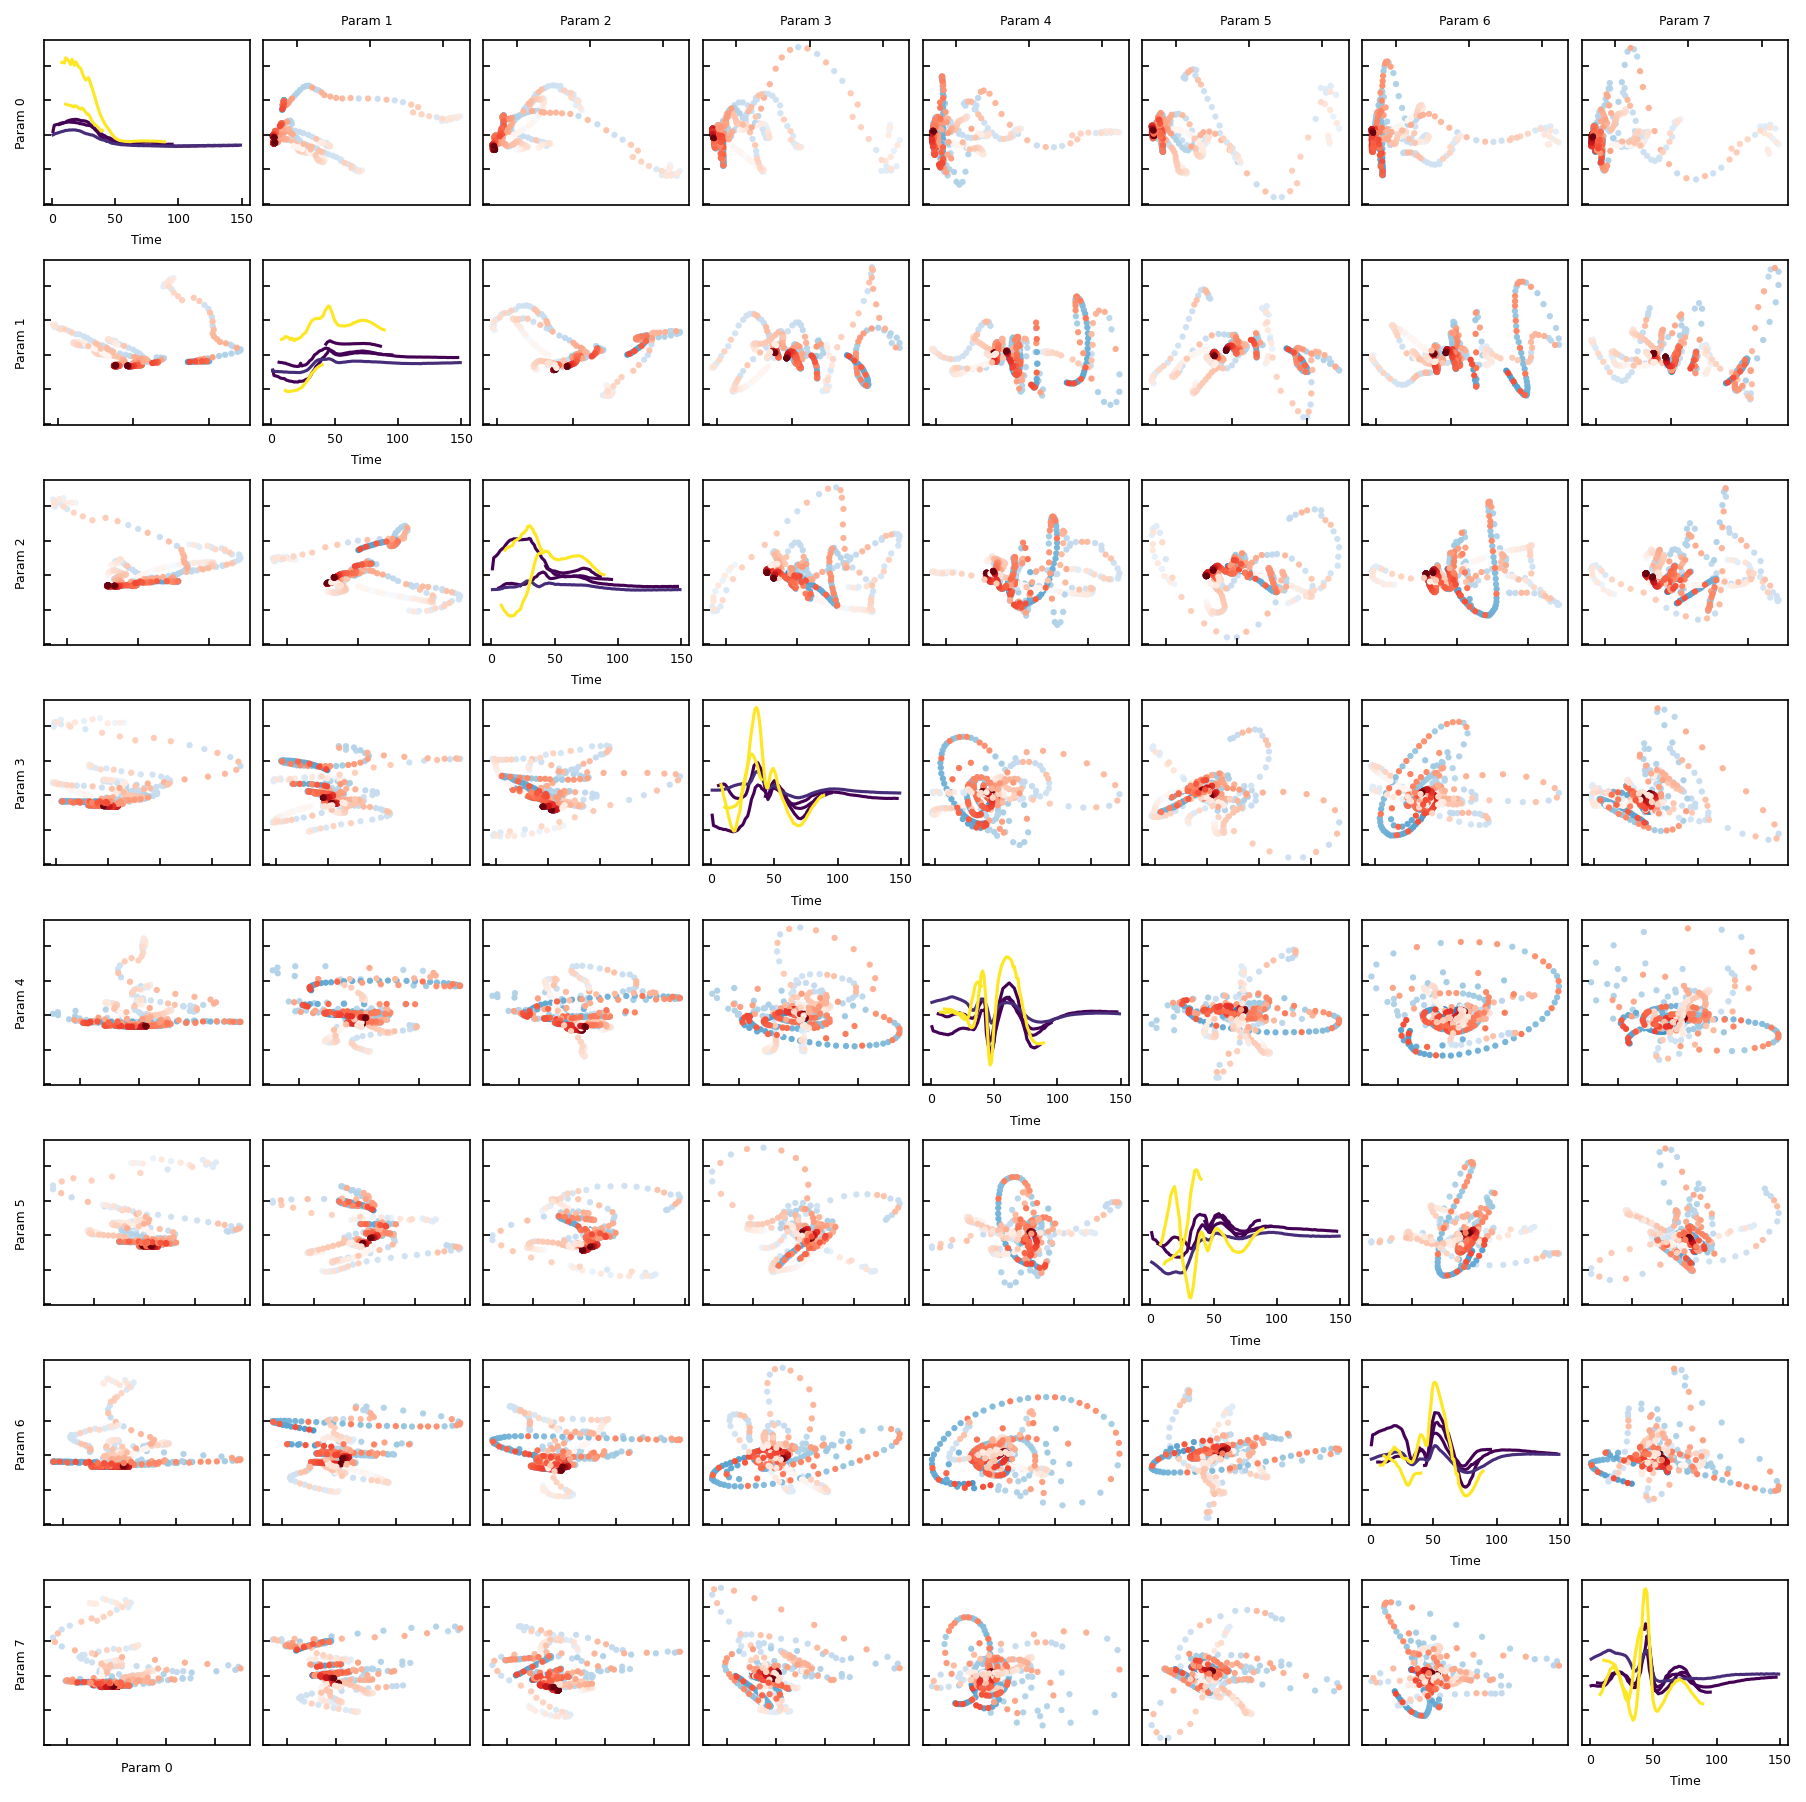

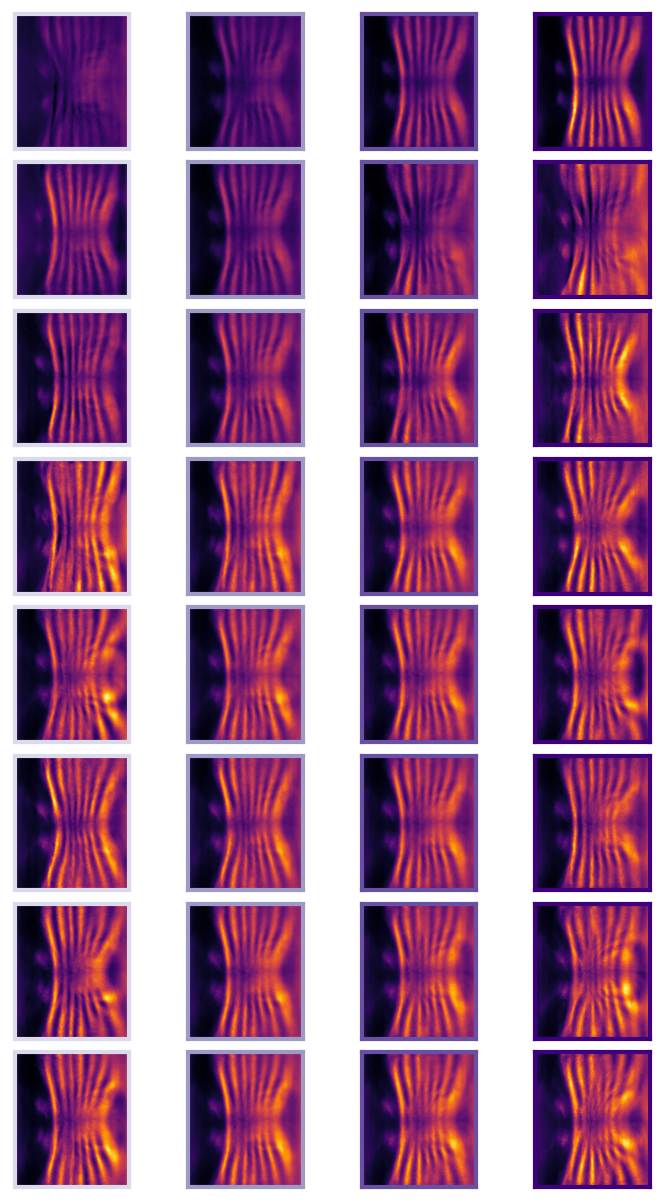

In [7]:
runt_model, runt_df = get_results(runt_dataset, n_components=32, whiten=True)
plot_fn = color_2D
summary_plot(runt_df, runt_model, runt_dataset, 25, show_magnitude=False, cutoff=0.8)
pca_plots(runt_df, runt_model, cutoff=0.8)

       time
set        
test    199
train   299


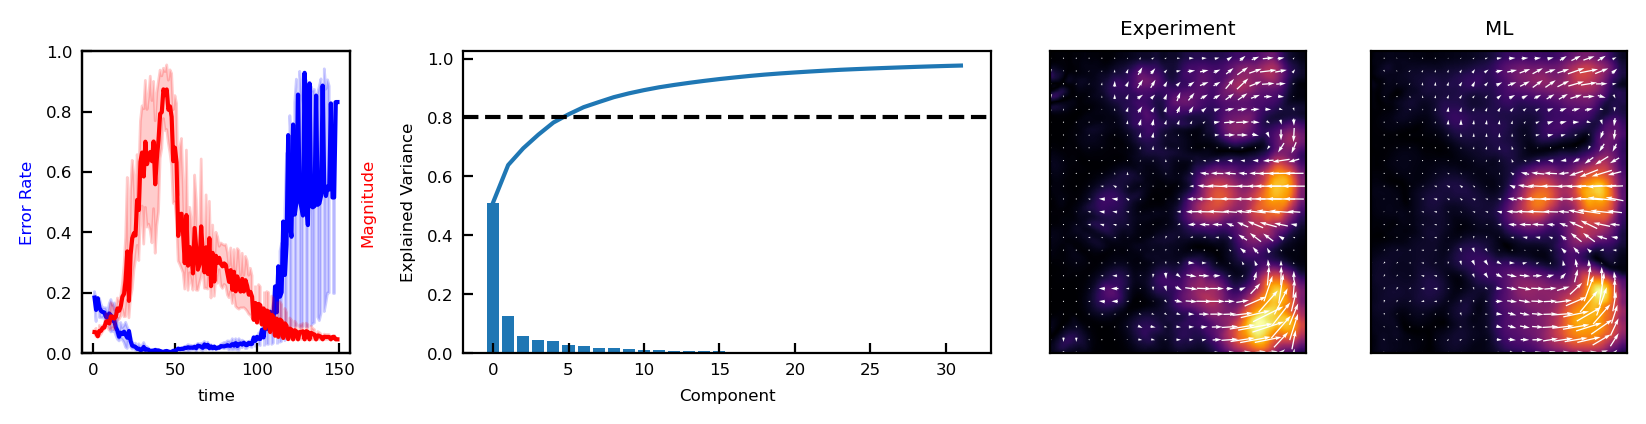

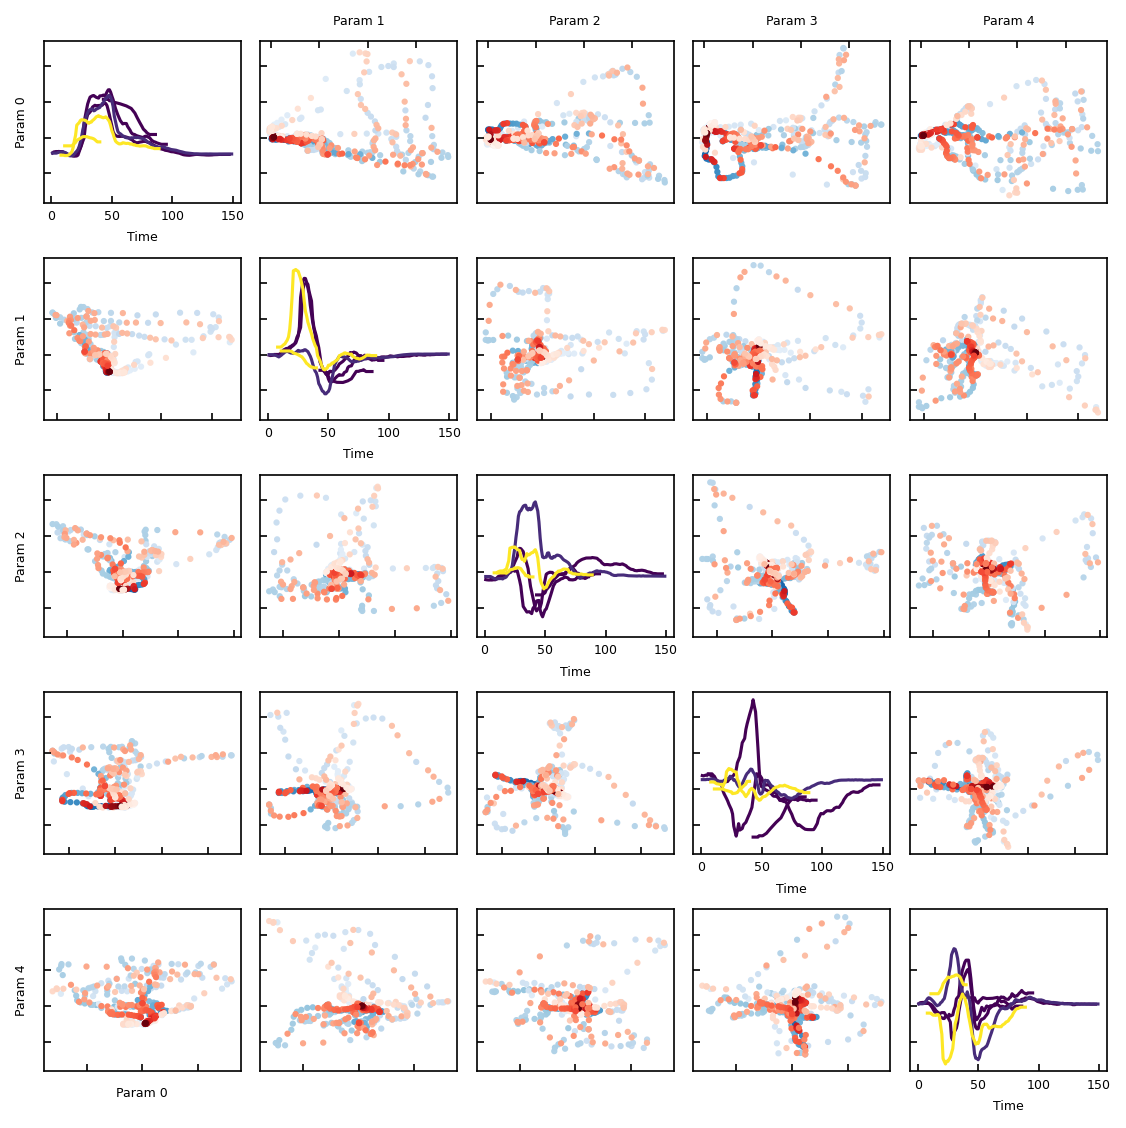

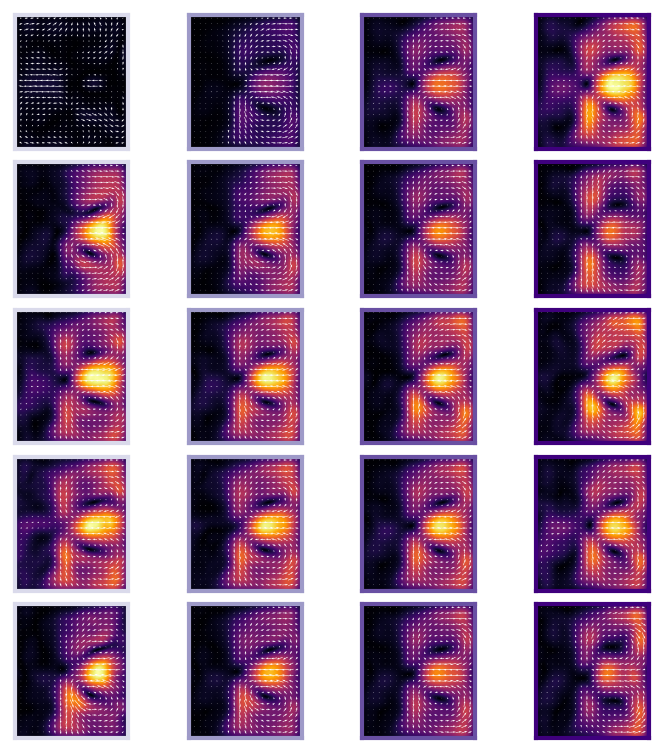

In [8]:
rvel_model, rvel_df = get_results(rvel_dataset, n_components=32, whiten=True)
plot_fn = plot_vector2D
summary_plot(rvel_df, rvel_model, rvel_dataset, 25, show_magnitude=True, cutoff=0.8)
pca_plots(rvel_df, rvel_model, cutoff=0.8)

## SINDy in PCA basis

In [282]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pysindy as ps
from pysindy.feature_library.pde_library import PDELibrary

from scipy.io import loadmat
geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

'''
Step 1. Choose datasets to use
'''
x_model, x_df = runt_model, runt_df.reset_index(drop=True)
u_model, u_df = rvel_model, rvel_df.reset_index(drop=True)

params_x = x_df.filter(like='param', axis=1).values
params_u = u_df.filter(like='param', axis=1).values

'''
Step 2. Establish component cutoff 
    Here, this is some threshold for the explained variance ratio
'''
keep_x = np.cumsum(x_model.explained_variance_ratio_) <= 0.9
keep_x[:2] = False #For runt, ignore the first two principal components
keep_u = np.cumsum(u_model.explained_variance_ratio_) <= 0.9

'''
Step 3. Project terms onto subset of meaningful components
'''

X = unpca(params_x[:, keep_x], x_model, keep_x)
U = unpca(params_u[:, keep_u], u_model, keep_u)

'''
Step 4. Compute derivatives
'''

#Split by embryo
diffY = ps.SmoothedFiniteDifference(d=1, axis=0)
diffX = ps.SmoothedFiniteDifference(d=1, axis=1)
diffT = ps.SmoothedFiniteDifference(d=1, axis=2)

tmin = 20
tmax = 90


feature_names = [
    'r',
    'grad^2 r',
    '(grad r)^2',
    'v^2', 
    'div v',
    'v grad r',
]

t = []
x = []
x_dot = []
x_true = []
u_true = []
for i, eID in enumerate(u_df.embryoID.unique()):
    data = u_df[u_df.embryoID == eID]
    data = data[(data.t >= tmin) & (data.t <= tmax)]
    idx = data.index

    if len(idx) < 30:
        continue
    
    xi = X[idx].transpose(2, 3, 0, 1)
    ui = U[idx].transpose(2, 3, 0, 1)
        
    x_dot.append(diffT._differentiate(xi, data.t.values))
    t.append(data.t.values)
    lib = []
    
    lib.append(xi)
    x_true.append(xi)
    u_true.append(ui)

    
    grad_x = np.stack([
        diffY._differentiate(xi, YY),
        diffX._differentiate(xi, XX),
    ], axis=-1)
    
    lapl_x = diffY._differentiate(grad_x[..., 0], YY) + \
             diffX._differentiate(grad_x[..., 1], XX)
    lib.append(lapl_x)
    
    grad2_x = np.power(grad_x, 2).sum(axis=-1)
    lib.append(grad2_x)
    
    u2 = np.power(ui, 2).sum(axis=-1, keepdims=True)
    lib.append(u2)
    
    grad_u = np.stack([
        diffY._differentiate(ui, YY),
        diffX._differentiate(ui, XX),
    ], axis=-1)
    
    div_u = grad_u[..., 0, 0:1] + grad_u[..., 1, 1:2]
    lib.append(div_u)
    
    u_grad_x = ui[..., 0:1] * grad_x[..., 0] + \
               ui[..., 1:2] * grad_x[..., 1]
    
    lib.append(u_grad_x)
    
    lib = np.concatenate(lib, axis=-1)
    print(lib.shape)
    
    x.append(lib.reshape([-1, lib.shape[-1]]))
    x_dot[-1] = x_dot[-1].reshape([-1, x_dot[-1].shape[-1]])
        
'''
Step 5. Fit model using SINDy
'''
model = ps.SINDy(
    feature_library=ps.IdentityLibrary(),
    optimizer=ps.STLSQ(threshold=0.5, alpha=0.),
    feature_names=feature_names
)

model.fit(x=x, x_dot=x_dot, multiple_trajectories=True)
model.print()

(236, 200, 71, 6)
(236, 200, 59, 6)
(236, 200, 63, 6)
(236, 200, 74, 6)
(r)' = 0.798 grad^2 r + -1.049 v grad r


In [283]:
from scipy.interpolate import interp1d

def evolve_rk4_grid(x0, xdot, pca, t, tmin=0, tmax=10, step_size=0.2):
    tt = np.arange(tmin, tmax, step_size)
    x = np.zeros([len(tt), *x0.shape])
    x[0] = x0
    
    print(x0.shape)
        
    interp = interp1d(t, xdot, axis=-2)
    for ii in range(len(tt)-1):
        k1 = interp(tt[ii])
        k2 = interp(tt[ii] + 0.5 * step_size)
        k3 = interp(tt[ii] + 0.5 * step_size)
        k4 = interp(tt[ii] + step_size)
        
        xtt = x[ii] + (k1 + 2 * k2 + 2 * k3 + k4) * step_size / 6
        
        #Project onto PCA components
        xtt = xtt.transpose(2, 0, 1).reshape([1, -1])
        xtt = unpca(pca.transform(xtt)[:, keep_x], pca, keep_x)[0]
        #xtt = xtt.transpose(1, 2, 0)
        x[ii+1] = xtt.transpose(1, 2, 0)

        
    return x.transpose(1, 2, 0, 3), tt

traj = 1
t0 = 25
dt = 25

x_dot_pred = model.model.predict(x[traj])
x_int = interp1d(t[traj], x_true[traj], axis=-2)
u_int = interp1d(t[traj], u_true[traj], axis=-2)
ic = x_int(t0)
x_dot_pred = x_dot_pred.reshape([*ic.shape[:-1], -1, 1])

x_pred, times = evolve_rk4_grid(ic, x_dot_pred, x_model, 
                                t=t[traj], tmin=t0, tmax=t0+dt)

(236, 200, 1)


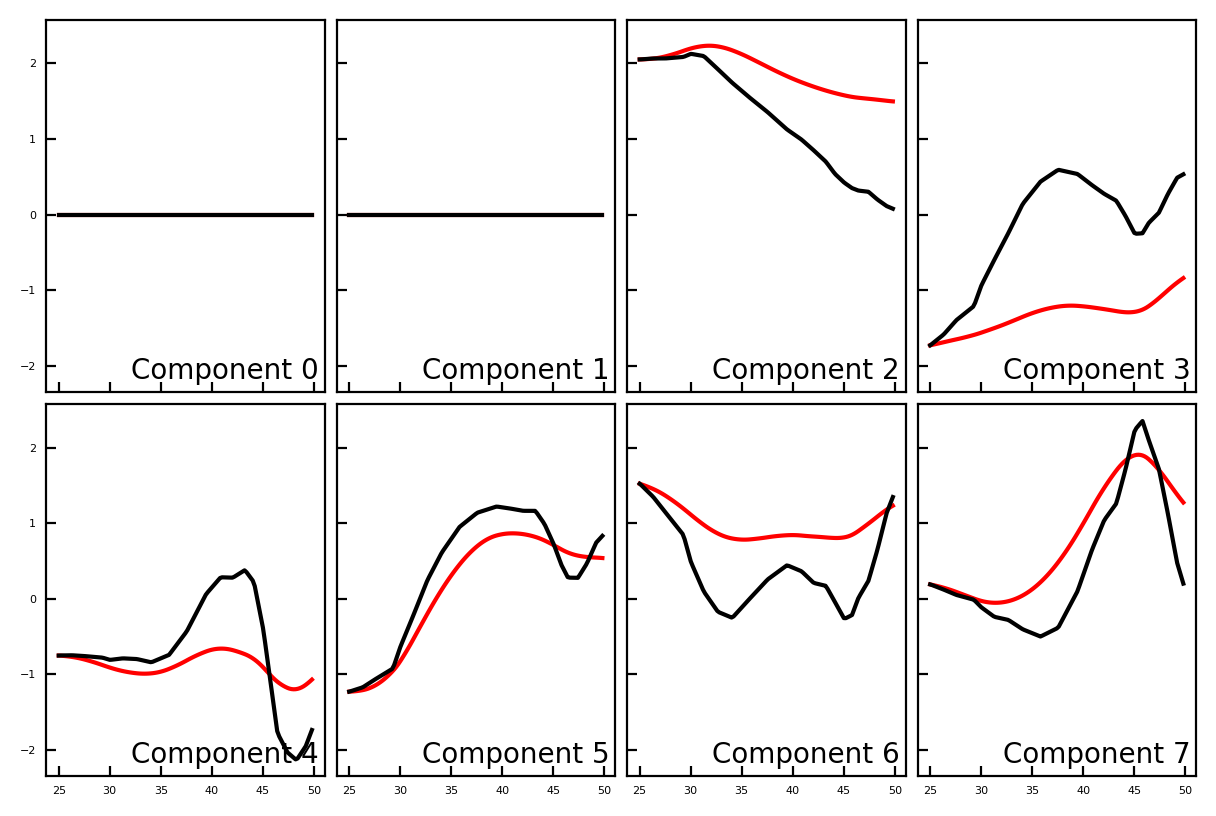

In [284]:
pca_pred = x_model.transform(x_pred.transpose(2, 3, 0, 1).reshape([x_pred.shape[-2], -1]))
pca_true = x_model.transform(x_int(times).transpose(2, 3, 0, 1).reshape([pca_pred.shape[0], -1]))

subset = np.cumsum(x_model.explained_variance_ratio_) <= 0.8

pca_pred = pca_pred[:, subset]
pca_true = pca_true[:, subset]

ncols = 4
fig, ax = plt.subplots(pca_pred.shape[1] // ncols, ncols, 
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

for i in range(len(ax)):
    ax[i].plot(times, pca_pred[:, i], color='red')
    ax[i].plot(times, pca_true[:, i], color='black')
    ax[i].text(0.98, 0.02, 'Component %d' % i, fontsize=10, 
               transform=ax[i].transAxes, va='bottom', ha='right')
plt.tight_layout()

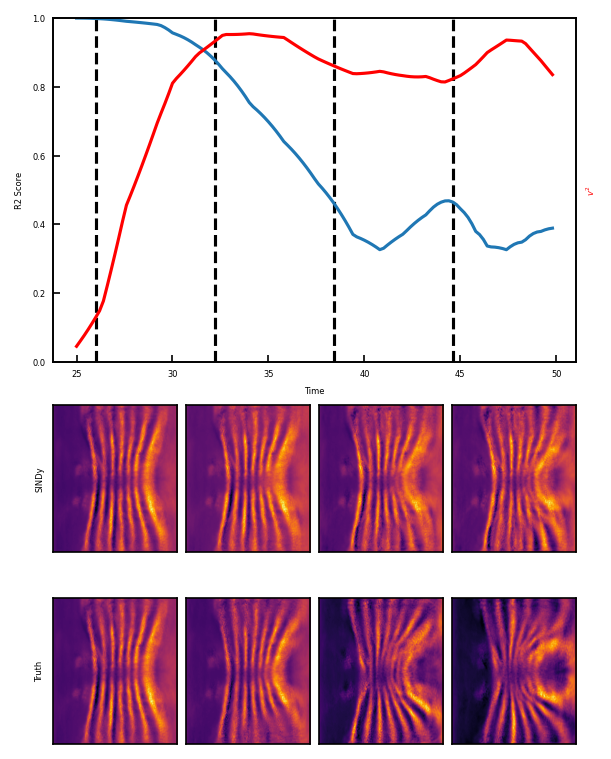

In [285]:
ncols = 4
step = x_pred.shape[-2] // ncols

fig = plt.figure(dpi=150, figsize=(1*ncols, 5))
gs = fig.add_gridspec(4, ncols)

plot_fn = color_2D
ax = fig.add_subplot(gs[:2, :])

from sklearn.metrics import r2_score

error = r2_score(
    x_pred.reshape([-1, x_pred.shape[-2]]),
    x_int(times).reshape([-1, x_pred.shape[-2]]),
    multioutput='raw_values'
)

v2 = np.linalg.norm(u_int(times), axis=-1).mean(axis=(0, 1))

ax.plot(times, error)
ax.set(ylim=[0, 1],
       ylabel='R2 Score',
       xlabel='Time')
ax2 = ax.twinx()
ax2.plot(times, v2, color='red')
ax2.set_yticks([])
ax2.set_ylabel('$v^2$', color='red')


offset = 5
for i in range(ncols):
    ii = i*step + offset
    color_2D(fig.add_subplot(gs[2, i]), x_pred[..., ii, 0])
    if i == 0:
        plt.gca().set_ylabel('SINDy')
    color_2D(fig.add_subplot(gs[3, i]), x_int(times[ii])[..., 0])
    if i == 0:
        plt.gca().set_ylabel('Truth')
    ax.axvline(times[ii], zorder=-1, color='black', linestyle='--')
    
plt.tight_layout()

## SINDy with PCA TransformedTarget Regressor

In [434]:
from sklearn.model_selection import train_test_split
import pysindy as ps
from pysindy.feature_library.pde_library import PDELibrary

from scipy.io import loadmat
geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

'''
Step 1. Choose datasets to use
'''
x_model, x_df = runt_model, runt_df.reset_index(drop=True)
u_model, u_df = rvel_model, rvel_df.reset_index(drop=True)

params_x = x_df.filter(like='param', axis=1).values
params_u = u_df.filter(like='param', axis=1).values

'''
Step 2. Establish component cutoff 
    Here, this is some threshold for the explained variance ratio
'''
keep_x = np.cumsum(x_model.explained_variance_ratio_) <= 0.9
keep_u = np.cumsum(u_model.explained_variance_ratio_) <= 0.9

'''
Step 3. Project terms onto subset of meaningful components
'''

X = unpca(params_x[:, keep_x], x_model, keep_x)
U = unpca(params_u[:, keep_u], u_model, keep_u)

'''
Step 4. Compute derivatives
'''

#Split by embryo
diffT = ps.SmoothedFiniteDifference(d=1, axis=0)
diffY = ps.SmoothedFiniteDifference(d=1, axis=-2)
diffX = ps.SmoothedFiniteDifference(d=1, axis=-1)

tmin = 20
tmax = 90


feature_names = [
    'r',
    'grad^2 r',
    '(grad r)^2',
    'v^2', 
    'div v',
    'v grad r',
]

t = []
x = []
x_dot = []
x_true = []
u_true = []
for i, eID in enumerate(u_df.embryoID.unique()):
    data = u_df[u_df.embryoID == eID]
    data = data[(data.t >= tmin) & (data.t <= tmax)]
    idx = data.index

    if len(idx) < 30:
        continue
    
    xi = X[idx]
    ui = U[idx]
        
    x_dot.append(diffT._differentiate(xi, data.t.values)[..., None])
    t.append(data.t.values)

    x_true.append(xi)
    u_true.append(ui)
    
    '''
    Pure scalar terms
    '''

    
    grad_x = np.stack([
        diffY._differentiate(xi, YY),
        diffX._differentiate(xi, XX),
    ], axis=-1)
    
    lapl_x = diffY._differentiate(grad_x[..., 0], YY) + \
             diffX._differentiate(grad_x[..., 1], XX)
    
    grad2_x = np.power(grad_x, 2).sum(axis=-1)
    
    '''
    Pure vector terms
    '''
    
    u2 = np.power(ui, 2).sum(axis=1, keepdims=True)
    
    diffY.axis = -2
    diffX.axis = -1
    
    grad_u = np.stack([
        diffY._differentiate(ui, YY),
        diffX._differentiate(ui, XX),
    ], axis=-1)
    
    div_u = grad_u[:, 0:1, ..., 0] = grad_u[:, 1:2, ..., 1]
    
    '''
    Mixed terms
    '''
    u_grad_x = ui[:, 0:1] * grad_x[..., 0] + \
               ui[:, 1:2] * grad_x[..., 1]
    
    
    lib = []
    lib.append(xi)
    lib.append(lapl_x)
    lib.append(grad2_x)
    lib.append(u2)
    lib.append(div_u)
    lib.append(u_grad_x)
    
    lib = np.stack(lib, axis=-1)    
    x.append(lib)
    print(x_dot[-1].shape, x[-1].shape)

(71, 1, 236, 200, 1) (71, 1, 236, 200, 6)
(59, 1, 236, 200, 1) (59, 1, 236, 200, 6)
(63, 1, 236, 200, 1) (63, 1, 236, 200, 6)
(74, 1, 236, 200, 1) (74, 1, 236, 200, 6)


(71, 1, 236, 200)


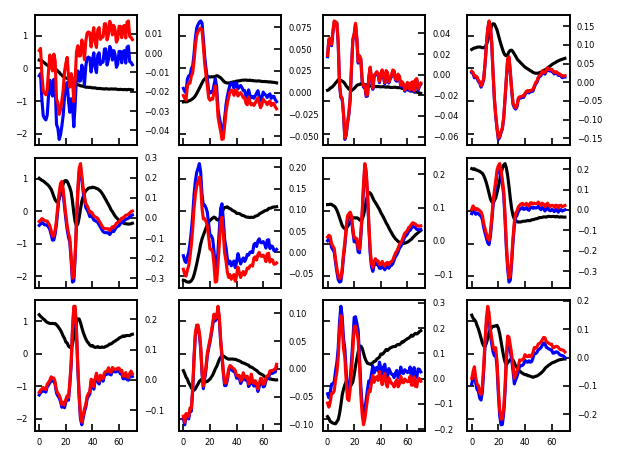

In [435]:
#Check that PCA behaves correctly under differentiation?

traj = 0
xi = x[traj][..., 0]
print(xi.shape)

pca_x = x_model.transform(xi.reshape([xi.shape[0], -1]))
d_pca_x = np.gradient(pca_x, axis=0)

pca_xd = x_model.transform(np.gradient(xi, axis=0).reshape([xi.shape[0], -1]))
pca_xd -= np.mean(pca_xd, axis=0, keepdims=True) #We have to remove bias to make this linear

subset = np.cumsum(x_model.explained_variance_ratio_) <= 0.85

pca_x = pca_x[:, subset]
pca_xd = pca_xd[:, subset]
d_pca_x = d_pca_x[:, subset]

ncols = 4
nrows = ceil(pca_x.shape[1] / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       figsize=(ncols, nrows),
                       sharey=True, sharex=True, dpi=150)
ax = ax.flatten()

for i in range(ax.shape[0]):
    ax[i].plot(pca_x[:, i], color='black')
    ax2 = ax[i].twinx()
    ax2.plot(d_pca_x[:, i], color='blue')
    ax2.plot(pca_xd[:, i], color='red')
    
plt.tight_layout()

(71, 1, 236, 200, 6)
(71, 236, 200, 7)


feature           min        max      mean       std
0       r_dot  1.253399e-09   0.114951  0.007905  0.010283
1           r  6.773657e-01   2.834998  1.058792  0.146623
2    grad^2 r  3.422747e-10   0.043211  0.001358  0.001795
3  (grad r)^2  1.630450e-12   0.020429  0.000128  0.000376
4         v^2  1.117515e-08  89.209130  1.909595  5.035569
5       div v  0.000000e+00   0.114327  0.005876  0.008417
6    v grad r  1.029143e-10   0.149236  0.004289  0.008396

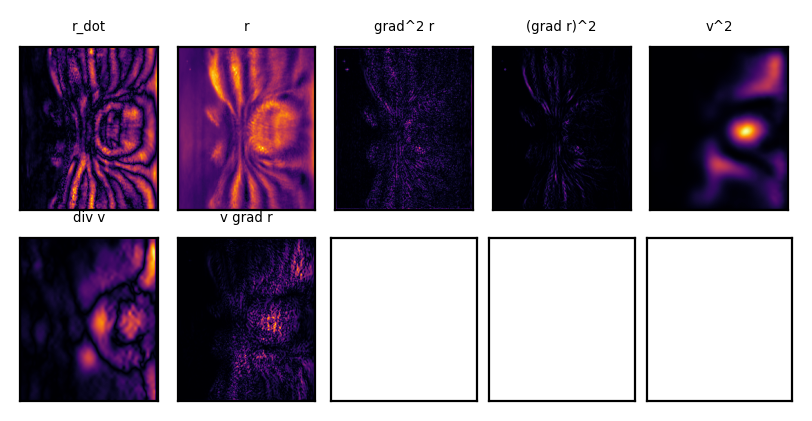

In [436]:
#Show library
from math import ceil

traj = 0
tt = 45

ncols = 5
nrows = ceil((x[traj].shape[-1]+1) / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       figsize=(.8*ncols, nrows),
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

plt.rcParams['font.size'] = 4

color_2D(ax[0], x_dot[traj][tt, ..., 0])
ax[0].set_title('r_dot')
for i in range(x[traj].shape[-1]):
    color_2D(ax[i+1], x[traj][tt, ..., i])
    ax[i+1].set_title(feature_names[i])

plt.tight_layout()
print(x[0].shape)
fnorm = np.linalg.norm(np.concatenate([x_dot[0], x[0]], axis=-1), axis=(1))
print(fnorm.shape)

df = pd.DataFrame({
    'feature': ['r_dot',] + feature_names,
    'min': np.min(fnorm, axis=(0, 1, 2)),
    'max': np.max(fnorm, axis=(0, 1, 2)),
    'mean': np.mean(fnorm, axis=(0, 1, 2)),
    'std': np.std(fnorm, axis=(0, 1, 2)),
})
df

In [437]:
'''
Step 5. Project library onto PCA basis
'''
def pca_trajectory(x):
    #x shape [T, C, Y, X, L]
    xi = x.transpose(0, 4, 1, 2, 3) # [T, L, C, Y, X]
    xi= xi.reshape([x.shape[0]*x.shape[-1], -1]) # [T*L, C, Y, X]
    xi = x_model.transform(xi) # [T*L, P]
    xi = xi.reshape([x.shape[0], -1, xi.shape[-1]]) # [T, L, P]
    xi -= np.mean(xi, axis=0, keepdims=True)
    xi = xi.transpose(0, 2, 1) #[T, P, L]
    return xi

keep_x = np.zeros(x_model.n_components_, dtype=bool)
keep_x[2:10] = True

x_pca = []
x_dot_pca = []
for i in range(len(x)):
    x_pca.append(pca_trajectory(x[i])[:, keep_x])
    x_dot_pca.append(pca_trajectory(x_dot[i])[:, keep_x])
    print(x[i].shape, x_pca[i].shape)

(71, 1, 236, 200, 6) (71, 8, 6)
(59, 1, 236, 200, 6) (59, 8, 6)
(63, 1, 236, 200, 6) (63, 8, 6)
(74, 1, 236, 200, 6) (74, 8, 6)


In [442]:
'''
Step 6. Fit model using SINDy
'''

model = ps.SINDy(
    feature_library=ps.IdentityLibrary(),
    optimizer=ps.STLSQ(threshold=0.5, alpha=0.1),
    feature_names=feature_names
)

model.fit(x=x_pca, x_dot=x_dot_pca, multiple_trajectories=True)
model.print()

(r)' = 3.573 grad^2 r + -4.487 (grad r)^2 + -3.731 v grad r


In [443]:
from scipy.interpolate import interp1d
from tqdm import tqdm

def evolve_rk4_grid(x0, xdot, pca, t, tmin=0, tmax=10, step_size=0.2):
    tt = np.arange(tmin, tmax, step_size)
    x = np.zeros([len(tt), *x0.shape])
    x[0] = x0
        
    interp = interp1d(t, xdot, axis=0)
    for ii in tqdm(range(len(tt)-1)):
        k1 = interp(tt[ii])
        k2 = interp(tt[ii] + 0.5 * step_size)
        k3 = interp(tt[ii] + 0.5 * step_size)
        k4 = interp(tt[ii] + step_size)
                
        xtt = x[ii] + (k1 + 2 * k2 + 2 * k3 + k4) * step_size / 6
        
        #Project onto PCA components
        xtt = xtt.reshape([1, -1])
        xtt = unpca(pca.transform(xtt)[:, keep_x], pca, keep_x).reshape(x[ii].shape)
        x[ii+1] = xtt

        
    return x, tt


traj = 1
t0 = 25
dt = 25

xi = x[traj]

x_dot_pred = model.model.predict(xi.reshape([-1, xi.shape[-1]])).reshape(x_dot[traj].shape)[..., 0]
print(x_dot_pred.shape)
x_int = interp1d(t[traj], x_true[traj], axis=0)
u_int = interp1d(t[traj], u_true[traj], axis=0)
ic = x_int(t0)

x_pred, times = evolve_rk4_grid(ic, x_dot_pred, x_model, 
                                t=t[traj], tmin=t0, tmax=t0+dt)

(59, 1, 236, 200)


100%|██████████| 124/124 [00:00<00:00, 169.53it/s]


(125, 32)


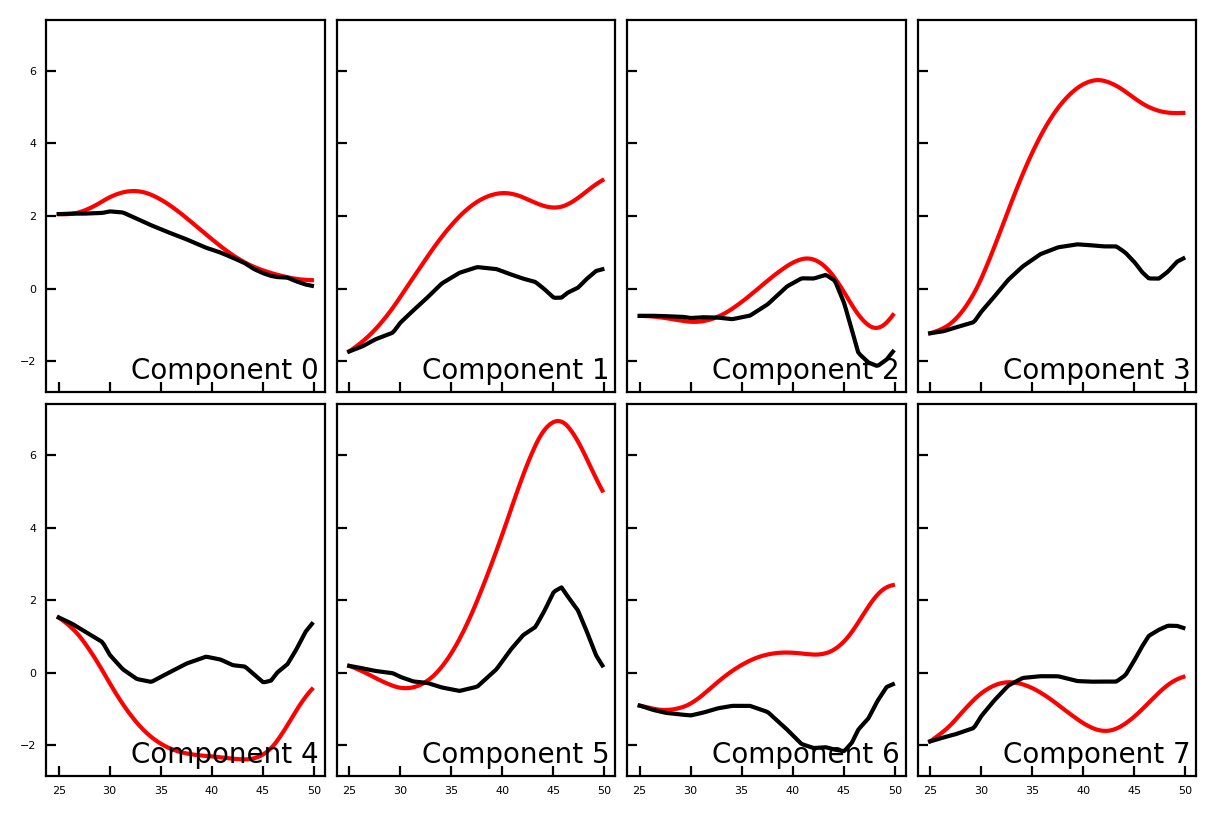

In [444]:
pca_pred = x_model.transform(x_pred.reshape([x_pred.shape[0], -1]))
pca_true = x_model.transform(x_int(times).reshape([pca_pred.shape[0], -1]))

print(pca_pred.shape)

pca_pred = pca_pred[:, keep_x]
pca_true = pca_true[:, keep_x]

ncols = 4
nrows = ceil(pca_pred.shape[1] / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

for i in range(pca_pred.shape[1]):
    ax[i].plot(times, pca_pred[:, i], color='red')
    ax[i].plot(times, pca_true[:, i], color='black')
    ax[i].text(0.98, 0.02, 'Component %d' % i, fontsize=10, 
               transform=ax[i].transAxes, va='bottom', ha='right')
plt.tight_layout()

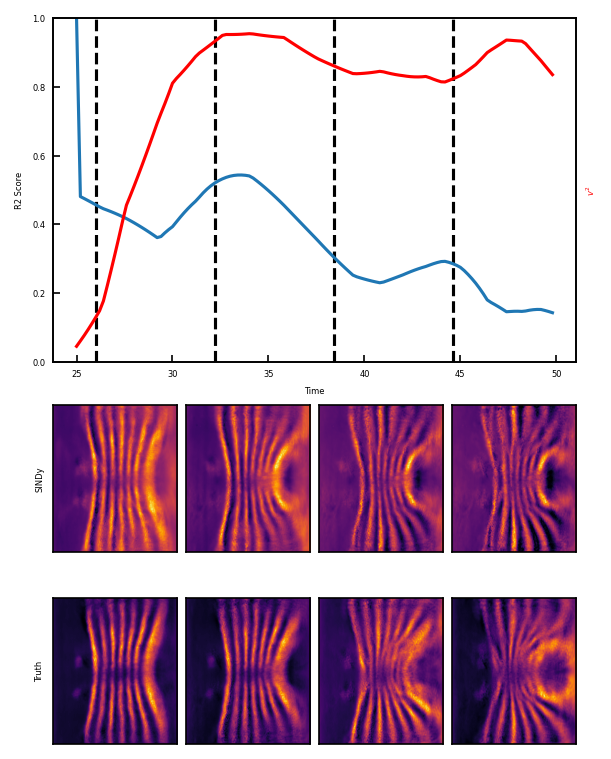

In [445]:
ncols = 4
step = x_pred.shape[0] // ncols

fig = plt.figure(dpi=150, figsize=(1*ncols, 5))
gs = fig.add_gridspec(4, ncols)

plot_fn = color_2D
ax = fig.add_subplot(gs[:2, :])

from sklearn.metrics import r2_score

error = r2_score(
    x_pred.reshape([x_pred.shape[0], -1]).T,
    x_int(times).reshape([x_pred.shape[0], -1]).T,
    multioutput='raw_values'
)

v2 = np.linalg.norm(u_int(times), axis=1).mean(axis=(1, 2))

ax.plot(times, error)
ax.set(ylim=[0, 1],
       ylabel='R2 Score',
       xlabel='Time')
ax2 = ax.twinx()
ax2.plot(times, v2, color='red')
ax2.set_yticks([])
ax2.set_ylabel('$v^2$', color='red')


offset = 5
for i in range(ncols):
    ii = i*step + offset
    color_2D(fig.add_subplot(gs[2, i]), x_pred[ii])
    if i == 0:
        plt.gca().set_ylabel('SINDy')
    color_2D(fig.add_subplot(gs[3, i]), x_int(times[ii]))
    if i == 0:
        plt.gca().set_ylabel('Truth')
    ax.axvline(times[ii], zorder=-1, color='black', linestyle='--')
    
plt.tight_layout()